# Optic flow connectivity analysis in FAFB

This script is about getting optic flow vectors in the medulla based on the main inputs of direction-selective (DS) T4 cells.
In a nutshell, it...
1. loads raw data from .csv.gz files, originally stored in the download section of Codex
2. organizes the data before grid creation
3. generates the 2D grid/lattice structure
4. plots the regular and hexagonal (honeycomb-like) grids using columnar coordinates in the medulla
5. plots and quantifies optic flow data on each type of grid/lattice

In [48]:
# Importing some packages
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
import pandas as pd
import seaborn as sns
import os
from fafbseg import flywire
from scipy.stats import gaussian_kde

# 1. Getting the data of interest

In [49]:
# Some user parameters
cell_for_grid = 'Mi1'

In [167]:
# Importing data from Codex
dataPath = R'D:\Connectomics-Data\FlyWire\Codex-datasets'
fileName = 'ol_columns.csv.gz'
filePath = os.path.join(dataPath,fileName)
columns_id_data = pd.read_csv(filePath, compression='gzip')
columns_id_data.rename(columns={"cell id": "root_id","cell type": "cell_type","column id": "column_id" }, inplace= True)

dataPath = R'D:\Connectomics-Data\FlyWire\Codex-datasets'
fileName = 'ol_metadata.csv.gz'
filePath = os.path.join(dataPath,fileName)
metadata = pd.read_csv(filePath, compression='gzip')

dataPath = R'D:\Connectomics-Data\FlyWire\Codex-datasets'
fileName = 'ol_connections.csv.gz'
filePath = os.path.join(dataPath,fileName)
ol_connections = pd.read_csv(filePath, compression='gzip')
ol_connections.rename(columns={"from cell id": "from_cell_id","to cell id": "to_cell_id" }, inplace= True)

dataPath = R'D:\Connectomics-Data\FlyWire\Codex-datasets'
fileName = 'column_assignment.csv.gz'
filePath = os.path.join(dataPath,fileName)
columns_id_coordinates = pd.read_csv(filePath, compression='gzip')

#Brief overview:
print('\n----------------- column data -----------------:\n')
print(columns_id_data)

print('\n------------------ metadata ------------------:\n')
print(metadata)
print('\n----------------- ol_connections ----------------:\n')
print(ol_connections)
print('\n----------------- coordinates ----------------:\n')
print(columns_id_coordinates)


----------------- column data -----------------:

                  root_id cell_type column_id
0      720575940596125868       T5c        97
1      720575940599333574       Tm1       355
2      720575940599457990       T4b       247
3      720575940599459782       T5b       513
4      720575940599704006       T5a       331
...                   ...       ...       ...
23447  720575940661201025        R8       701
23448  720575940661224065       T4a       390
23449  720575940661245825        C3       183
23450  720575940661264001        C3        38
23451  720575940661284993        R8       694

[23452 rows x 3 columns]

------------------ metadata ------------------:

                 attribute    value
0   number of cells mapped    22578
1  synapses inside columns  1381915
2   synapses cross columns   811545

----------------- ol_connections ----------------:

              from_cell_id          to_cell_id  synapses
0       720575940596125868  720575940622955561         2
1       72

In [168]:
# Discalimer: there are some T cells which have no "home" column_id assigned. Look this and compare numbers:

print('Total number of T4 cells:')
print(len(columns_id_data[columns_id_data.cell_type.isin(['T4a','T4b','T4c','T4d'])].root_id.unique()))
print('Total number of T4 cells assigned to a column:')
print(len(columns_id_coordinates[columns_id_coordinates.type.isin(['T4a','T4b','T4c','T4d'])].root_id.unique()))

Total number of T4 cells:
3103
Total number of T4 cells assigned to a column:
2998


## 1.1 Combining the data of interest into useful data frames

In [169]:
## Completing the "ol_connections" data frame
# Adding cell type names and their columns ids

ol_connections_extended = ol_connections.copy()

# Merge to add from_cell_type
ol_connections_extended = ol_connections_extended.merge(
    columns_id_data[['root_id', 'cell_type','column_id']],
    how='left',
    left_on='from_cell_id',
    right_on='root_id'
).rename(columns={'cell_type': 'from_cell_type','column_id': 'from_column_id'}).drop(columns=['root_id'])

# Merge to add to_cell_type
ol_connections_extended = ol_connections_extended.merge(
    columns_id_data[['root_id', 'cell_type','column_id']],
    how='left',
    left_on='to_cell_id',
    right_on='root_id'
).rename(columns={'cell_type': 'to_cell_type','column_id': 'to_column_id'}).drop(columns=['root_id'])

# Display the updated ol_connections data frame
print(ol_connections_extended)

# Print
print('\nAvailable cell types with column id data:')
print(ol_connections_extended.from_cell_type.unique())

              from_cell_id          to_cell_id  synapses from_cell_type  \
0       720575940596125868  720575940622955561         2            T5c   
1       720575940599333574  720575940617904614         7            Tm1   
2       720575940599333574  720575940629129692        22            Tm1   
3       720575940599333574  720575940612157041        11            Tm1   
4       720575940599333574  720575940609269771         4            Tm1   
...                    ...                 ...       ...            ...   
270851  720575940661264001  720575940613285034         3             C3   
270852  720575940661264001  720575940647104291        87             C3   
270853  720575940661264001  720575940638965155        17             C3   
270854  720575940661284993  720575940628173394         3             R8   
270855  720575940661284993  720575940624106948         7             R8   

       from_column_id to_cell_type to_column_id  
0                  97          T5c          443  

# 2. Organizing the data before grid creation

## 2.1 Getting the cells of reference (usually Mi1s) for creating a 2D lattice

In [170]:
# Looking deeply at the match between individual cells and individual columns
cells_columns = columns_id_data[columns_id_data['cell_type'] == cell_for_grid]
number_unique_cells = len(cells_columns['root_id'].unique())
if 'not assigned' in cells_columns['column_id'].unique():
    number_unique_columns = len(cells_columns['column_id'].unique())-1 #-1 to compensate for "not assigned label" of some cells
else:
    number_unique_columns = len(cells_columns['column_id'].unique())
    

print(f'Total number of unique cells: {number_unique_cells}')
print(f'Total number of unique columns: {number_unique_columns}')
print(f'Missmatch: {number_unique_cells - number_unique_columns}')

# Identify duplicate values in 'column id'
duplicates = cells_columns[cells_columns.duplicated('column_id', keep=False)]

print(f'Number of duplicates / cells not assigned to columns: {len(duplicates)}')

# Filter out rows with repetitive values
filtered_cells_columns = cells_columns[~cells_columns['column_id'].isin(duplicates['column_id'])]
print(f'Filtered data length: {len(filtered_cells_columns)}')

# Addining column coordinates information
df_grid =  pd.merge(filtered_cells_columns, columns_id_coordinates[['root_id', 'p', 'q', 'x', 'y']], on='root_id', how='left')
print(f'Final df_grid length: {len(df_grid)}')
display(df_grid.head())

Total number of unique cells: 796
Total number of unique columns: 796
Missmatch: 0
Number of duplicates / cells not assigned to columns: 0
Filtered data length: 796
Final df_grid length: 796


root_id cell_type column_id   p   q  x   y
0  720575940603042272       Mi1         1  12   1  6  13
1  720575940603200428       Mi1         2   9  -7  8   2
2  720575940603327916       Mi1         3 -12   0 -6 -12
3  720575940603935334       Mi1         4  -6 -15  5 -21
4  720575940604151008       Mi1         6   0  -4  2  -4

## 2.2 Getting the cells of interest (usually a T4 subtype) for optic flow analysis

In [171]:
# Looking deeply at the match between individual cells and individual columns
cell_of_interest = 'T4a'
cells_columns = columns_id_data[columns_id_data['cell_type'] == cell_of_interest]
number_unique_cells = len(cells_columns['root_id'].unique())
if 'not assigned' in cells_columns['column_id'].unique():
    number_unique_columns = len(cells_columns['column_id'].unique())-1 #-1 to compensate for "not assigned label" of some cells
else:
    number_unique_columns = len(cells_columns['column_id'].unique())

print(f'Total number of unique cells: {number_unique_cells}')
print(f'Total number of unique columns: {number_unique_columns}')
print(f'Missmatch: {number_unique_cells - number_unique_columns}')

# Identify duplicate values in 'column id'
duplicates = cells_columns[cells_columns.duplicated('column_id', keep=False)]

print(f'Number of duplicates / cells not assigned to columns: {len(duplicates)}')

# Filter out rows with repetitive values
filtered_cells_columns = cells_columns[~cells_columns['column_id'].isin(duplicates['column_id'])]
print(f'Filtered data length: {len(filtered_cells_columns)}')

# Addining column coordinates information
df =  pd.merge(filtered_cells_columns, columns_id_coordinates[['root_id', 'p', 'q', 'x', 'y']], on='root_id', how='left')
print(f'Final df length: {len(df)}')
display(df.head())

# Filtering the ol_connections_extended data frame:
ol_connections_extended_cell_of_interest = ol_connections_extended[ol_connections_extended.to_cell_type == cell_of_interest].copy()
print('\nTotal number of unique cells and columns must fit with previous data sets:\n')
len_cells_in_ol_connections_extended = len(ol_connections_extended_cell_of_interest.to_cell_id.unique())
len_columns_in_ol_connections_extended = len(ol_connections_extended_cell_of_interest.to_column_id.unique())  -1# -1 to compensate for "not assigned label"
print(f'ol_connections_extended num of cells / columns: {len_cells_in_ol_connections_extended} / {len_columns_in_ol_connections_extended}')
display(ol_connections_extended_cell_of_interest.head())

# Checking ol_connections from a cell of interest
from_cell_of_interest = 'Mi4'
len_connected_cells = len(ol_connections_extended_cell_of_interest[ol_connections_extended_cell_of_interest.from_cell_type == from_cell_of_interest].to_cell_id.unique())
len_connected_columns = len(ol_connections_extended_cell_of_interest[ol_connections_extended_cell_of_interest.from_cell_type == from_cell_of_interest].to_column_id.unique())
print(f'\nTotal number of unique cells / columns connected with {from_cell_of_interest}: {len_connected_cells} / {len_connected_columns} \n')
display(ol_connections_extended_cell_of_interest[ol_connections_extended_cell_of_interest.from_cell_type == from_cell_of_interest].head())


Total number of unique cells: 737
Total number of unique columns: 725
Missmatch: 12
Number of duplicates / cells not assigned to columns: 12
Filtered data length: 725
Final df length: 725


root_id cell_type column_id  p   q  x   y
0  720575940599755718       T4a       741 -4  -8  2 -12
1  720575940600101641       T4a       487 -2   1 -1  -1
2  720575940600143369       T4a       662 -3   2 -2  -1
3  720575940600547529       T4a       727 -4  10 -7   6
4  720575940603491957       T4a       391 -6   3 -4  -3


Total number of unique cells and columns must fit with previous data sets:

ol_connections_extended num of cells / columns: 737 / 725


from_cell_id          to_cell_id  synapses from_cell_type  \
37   720575940599457990  720575940614620381         2            T4b   
60   720575940599755718  720575940640779984         3            T4a   
64   720575940599755718  720575940626967311         2            T4a   
99   720575940600101641  720575940634499832         2            T4a   
101  720575940600101641  720575940621551220         2            T4a   

    from_column_id to_cell_type to_column_id  
37             247          T4a          244  
60             741          T4a          634  
64             741          T4a          530  
99             487          T4a          372  
101            487          T4a          181


Total number of unique cells / columns connected with Mi4: 664 / 655 



from_cell_id          to_cell_id  synapses from_cell_type  \
313   720575940602943968  720575940627598852         5            Mi4   
316   720575940602943968  720575940619209408         7            Mi4   
1350  720575940604209580  720575940610253410         3            Mi4   
2590  720575940604941024  720575940605803744         3            Mi4   
2591  720575940604941024  720575940649880441         4            Mi4   

     from_column_id to_cell_type to_column_id  
313             205          T4a          369  
316             205          T4a          137  
1350            550          T4a          236  
2590            526          T4a          549  
2591            526          T4a          656

# 3. Generating the 2D grid/lattice structure

In [172]:
def plot_hex_grid(x, y, hex_size=1.0, spacing=1.5, fig_size=(10, 10), labels=None, label_type='column_id', text_size=10):
    """
    Plots a hexagonal grid using the provided x and y coordinates.

    Parameters:
    -----------
    x : list or array-like
        List of x coordinates for the centers of the hexagons.
    y : list or array-like
        List of y coordinates for the centers of the hexagons.
    hex_size : float, optional
        The size of each hexagon, defined as the distance from the center to any vertex. Default is 1.0.
    spacing : float, optional
        The amount of space between hexagons. Default is 1.5.
    fig_size : tuple, optional
        Size of the figure (width, height) in inches. Default is (10, 10).
    labels : list, optional
        Labels to be displayed inside each hexagon. Must match the length of x and y.
    label_type : str, optional
        Type of labels to be displayed. Options are:
        - 'manual_labels': Use the provided labels.
        - 'xy': Display the coordinates (x, y) as labels.
        Default is 'column_id'.
    text_size : int, optional
        Font size of the labels inside the hexagons. Default is 10.

    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object containing the plot.
    ax : matplotlib.axes._subplots.AxesSubplot
        The axes object containing the plot.
    hexagons : list of matplotlib.patches.Polygon
        List of hexagon patch objects used in the plot.
    """
    fig, ax = plt.subplots(figsize=fig_size)
    ax.set_aspect('equal')
    
    hexagons = []
    
    def hexagon_vertices(x_center, y_center):
        """Calculate the vertices of a hexagon given its center coordinates."""
        angles = np.linspace(0, 2*np.pi, 7) + np.pi/2
        vertices = [(x_center + hex_size * np.cos(angle), y_center + hex_size * np.sin(angle)) for angle in angles]
        return vertices
    
    for i in range(len(x)):
        vertices = hexagon_vertices(x[i], y[i])
        hexagon = Polygon(vertices, edgecolor='black', linewidth=1, facecolor='none')
        ax.add_patch(hexagon)
        hexagons.append(hexagon)
        
        if label_type == 'manual_labels' and labels:
            label = labels[i]
        elif label_type == 'xy':
            label = f'({x[i]}, {y[i]})'
        else:
            label = ''
        
        if label:
            x_center = x[i]
            y_center = y[i]
            ax.text(x_center, y_center, label, ha='center', va='center', fontsize=text_size)
    
    ax.set_xlim(min(x) - hex_size - spacing, max(x) + hex_size + spacing)
    ax.set_ylim(min(y) - hex_size - spacing, max(y) + hex_size + spacing)
    
    ax.autoscale_view()
    
    return fig, ax, hexagons


def draw_vector(ax, x_start, y_start, x_end, y_end, linewidth=2, head_size=0.5, **kwargs):
    """
    Draws a vector (arrow) on the provided axes from a starting point to an ending point.

    Parameters:
    -----------
    ax : matplotlib.axes._subplots.AxesSubplot
        The axes on which to draw the vector.
    x_start : float
        The x coordinate of the start point of the vector.
    y_start : float
        The y coordinate of the start point of the vector.
    x_end : float
        The x coordinate of the end point of the vector.
    y_end : float
        The y coordinate of the end point of the vector.
    linewidth : float, optional
        The width of the vector's line. Default is 2.
    head_size : float, optional
        The size of the arrowhead. Default is 0.5.
    **kwargs : dict, optional
        Additional keyword arguments to customize the arrow properties.

    Returns:
    --------
    None
    """
    arrow_style = f'-|>,head_width={head_size},head_length={head_size * 1.5}'
    ax.annotate('', xy=(x_end, y_end), xytext=(x_start, y_start),
                arrowprops=dict(arrowstyle=arrow_style, linewidth=linewidth, fill=True, **kwargs))


def calculate_new_p_values(original_x, original_y, start_key=-16, end_key=17, relative_change=0.5, in_space=0):
    """
    Calculates new x values by applying a relative change based on a mapping of y values.

    Parameters:
    -----------
    original_x : list or array-like
        The original x values to be adjusted.
    original_y : list or array-like
        The corresponding y values used to determine the adjustment.
    start_key : int, optional
        The starting key for the range of y values to be mapped. Default is -16.
    end_key : int, optional
        The ending key for the range of y values to be mapped. Default is 17.
    relative_change : float, optional
        The factor by which x values will be adjusted. Default is 0.5.
    in_space : int, optional
        An optional parameter for additional spacing or modification. Default is 0.

    Returns:
    --------
    new_x_values : list
        A list of new x values after applying the relative change based on y values.
    """
    shift_dict = {}

    for i in range(start_key, end_key + 1):
        value = (i - start_key) * relative_change
        shift_dict[i] = value

    new_x_values = []

    for x, y in zip(original_x, original_y):
        if y in shift_dict:
            relative_change = shift_dict[y]
            new_x = x - relative_change
            new_x_values.append(new_x)
        else:
            new_x_values.append(x)

    return new_x_values


def add_space_in_between(num_negatives, num_positives, space, key_list):
    """
    Adds space between negative and positive values and returns a new list based on a provided key list.

    Parameters:
    -----------
    num_negatives : int
        The number of negative values to generate.
    num_positives : int
        The number of positive values to generate.
    space : float
        The spacing factor between the values.
    key_list : list
        A list of keys to generate the corresponding spaced values.

    Returns:
    --------
    new_list : list
        A list of values generated based on the key list with added spacing.
    """
    negative_numbers = [-space * i for i in range(num_negatives, 0, -1)]
    positive_numbers = [space * i for i in range(1, num_positives + 1)]
    generated_list = negative_numbers + [0] + positive_numbers
    original_range = list(range(-num_negatives, num_positives + 1))
    
    space_dict = {}
    for i, key in enumerate(original_range):
        if i < len(generated_list):
            space_dict[key] = generated_list[i]
        else:
            space_dict[key] = None

    new_list = [space_dict.get(key, None) for key in key_list]
    
    return new_list


### Ploting a regular grid

In [173]:
## Preparing data to plot
#Important axis across the eye/medulla ( in terms of p,q coordinates)
'''
The ommatidia directions are well described by a hexagonal grid that we then aligned to the medulla column grid using 
the equator (+h) and central meridian (+v) as global landmarks
'''
h_x_ls = list(range(-8,8+1,1))
h_y_ls = list(range(8,-8-1,-1))
h = list(zip(h_x_ls,h_y_ls))

v_x_ls = list(range(-14,15+1,1))
v_y_ls = v_x_ls
v = list(zip(v_x_ls,v_y_ls))

p_y_ls = list(range(14,-13-1,-1))
p_x_ls = [0]* len(p_y_ls)
p = list(zip(p_x_ls,p_y_ls))

q_x_ls = list(range(-14,14+1,+1))
q_y_ls = [0]* len(q_x_ls)
q = list(zip(q_x_ls,q_y_ls))

'''
Seb, it would be good to calculate a new _new_x_ls and new_? 
(e.g., new_q_x_ls and new_q) using the function calculate_new_p_values
'''


## Given coordinates and labels (data)
# Original coordinates
original_p = df_grid.p.tolist()
original_q = df_grid.q.tolist()

# Shifting and spacing x coordinates
_relative_change = 0.58 # This number has been manually adjusted. Find a way to input the value based on pure geometry
_space = 1.15 # This number has been manually adjusted. Find a way to input the value based on pure geometry
min_p_value = 18 # although is negative, write it as positive
max_p_value = 18 
min_q_value = -16
max_q_value = 17
spaced_original_p  = add_space_in_between(min_p_value, max_p_value, _space, original_p) #(min_x_value, max_x_value, space, original_p)
new_p_values = calculate_new_p_values(spaced_original_p, original_q, start_key=min_q_value , end_key=max_q_value , relative_change=_relative_change, in_space=0)
df_grid['new_p'] = new_p_values
center_shift = df_grid[df_grid.column_id == '628'].new_p.values[0] # Centering the original (0,0) coordinate again to 0,0
new_centered_p_values = new_p_values  - center_shift
df_grid['new_centered_p'] = new_centered_p_values


# "manual_labels" column ids
labels = df_grid.column_id.tolist() 

# "manual_labels" original coordinates
labels = list(zip(original_p, original_q)) 
labels = [f"({x}, {y})" for x, y in labels]



Using original p and q coordinate values

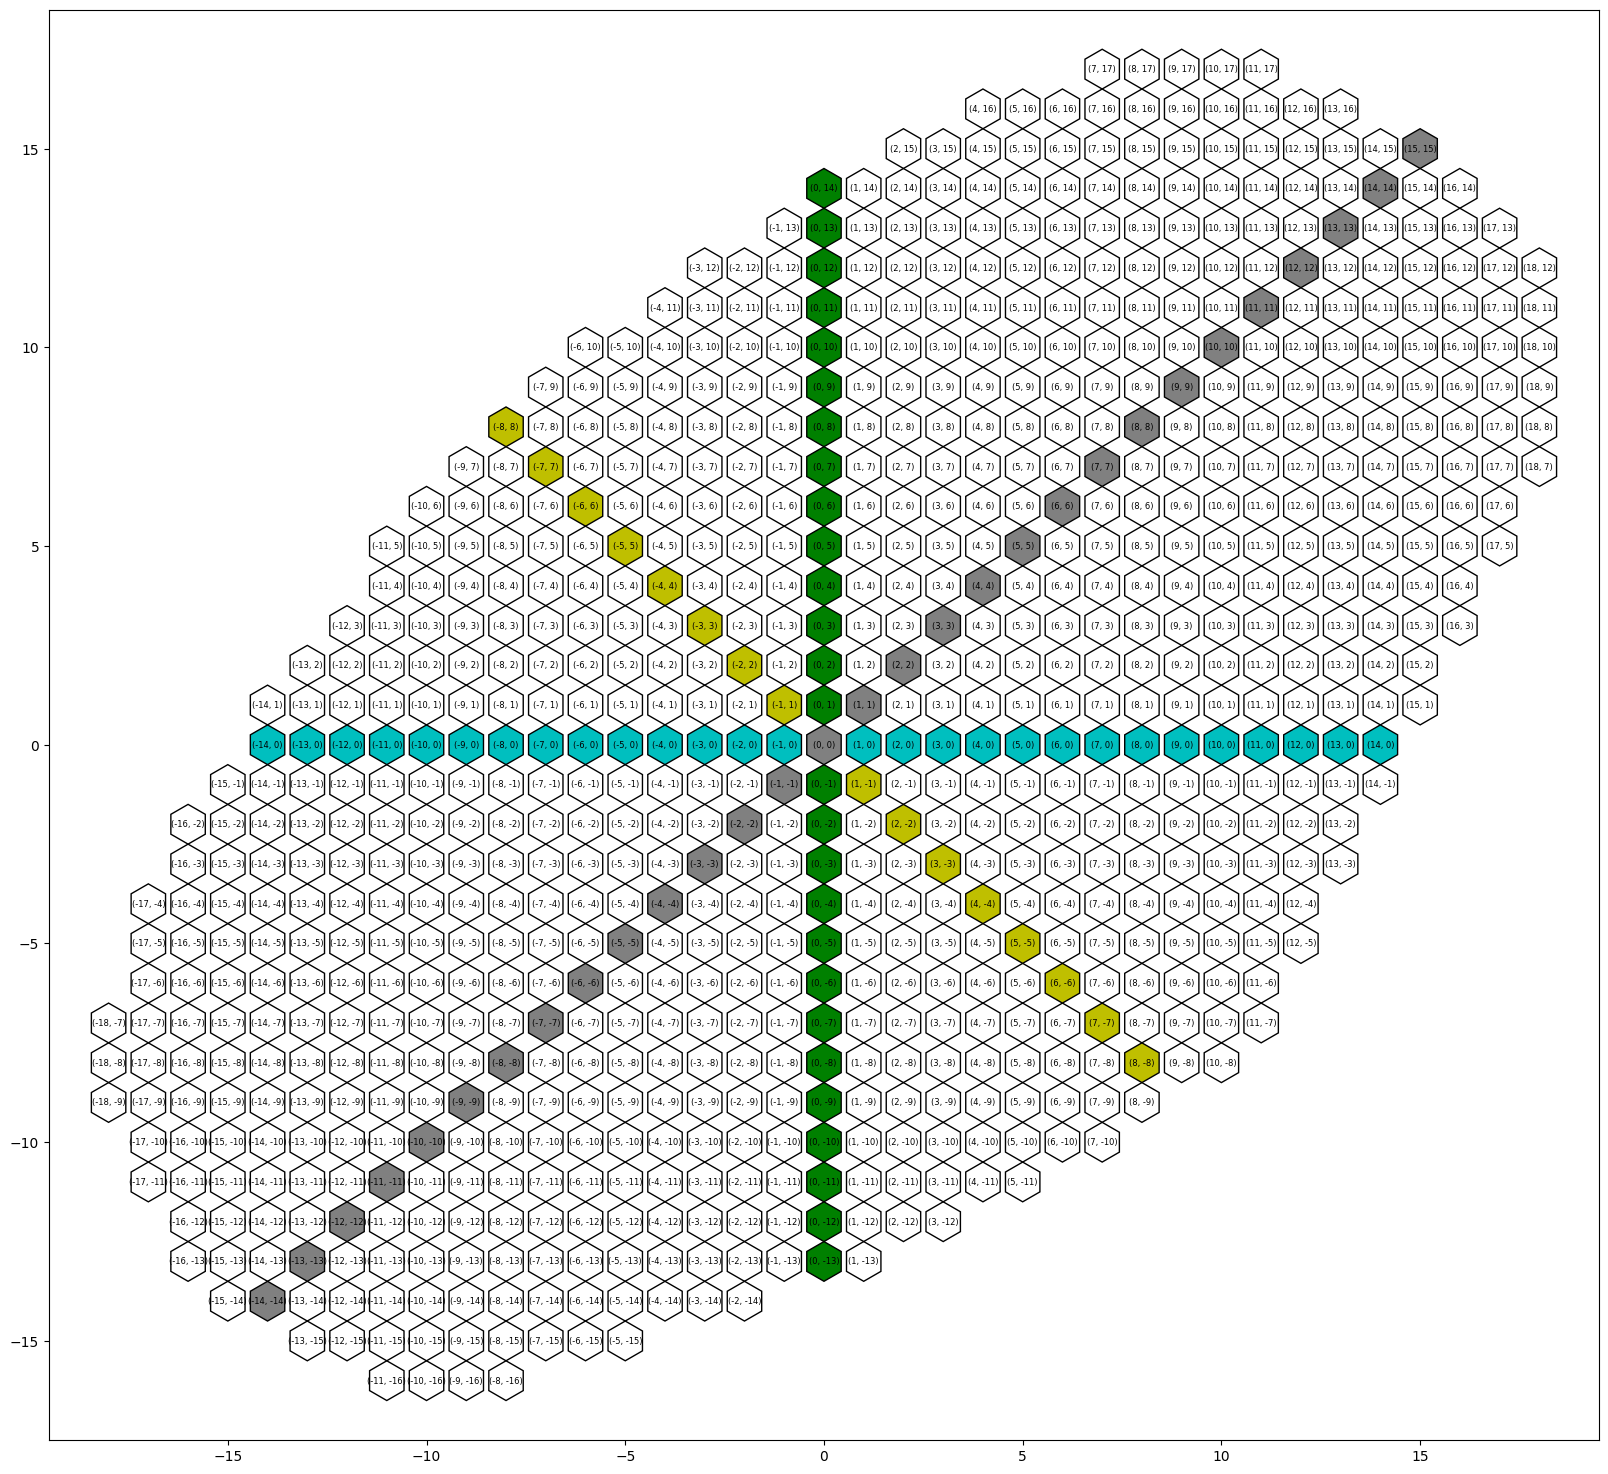

In [174]:
## Plotting on the 2D lattice: check access to each point and axis
fig, ax, hexagons = plot_hex_grid(original_p, original_q, hex_size=0.5, spacing=1.0, fig_size=(20, 20), labels=labels, label_type='manual_labels', text_size=6)

# Example to color hexagons based on a condition
for p_x, p_y in p:
    color_in_p = p_x
    color_in_q = p_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(original_p, original_q)):
        if x_pos == color_in_p and y_pos == color_in_q:
            hexagon.set_facecolor('g')

for q_x, q_y in q:
    color_in_p = q_x
    color_in_q = q_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(original_p, original_q)):
        if x_pos == color_in_p and y_pos == color_in_q:
            hexagon.set_facecolor('c')
            
# h = eye's equator
for h_x, h_y in h:
    color_in_p = h_x
    color_in_q = h_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(original_p, original_q)):
        if x_pos == color_in_p and y_pos == color_in_q:
            hexagon.set_facecolor('y')


for v_x, v_y in v:
    color_in_p = v_x
    color_in_q = v_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(original_p, original_q)):
        if x_pos == color_in_p and y_pos == color_in_q:
            hexagon.set_facecolor('grey')





### Ploting hexagonal grids

Using original q but new calculated p coordinate values.

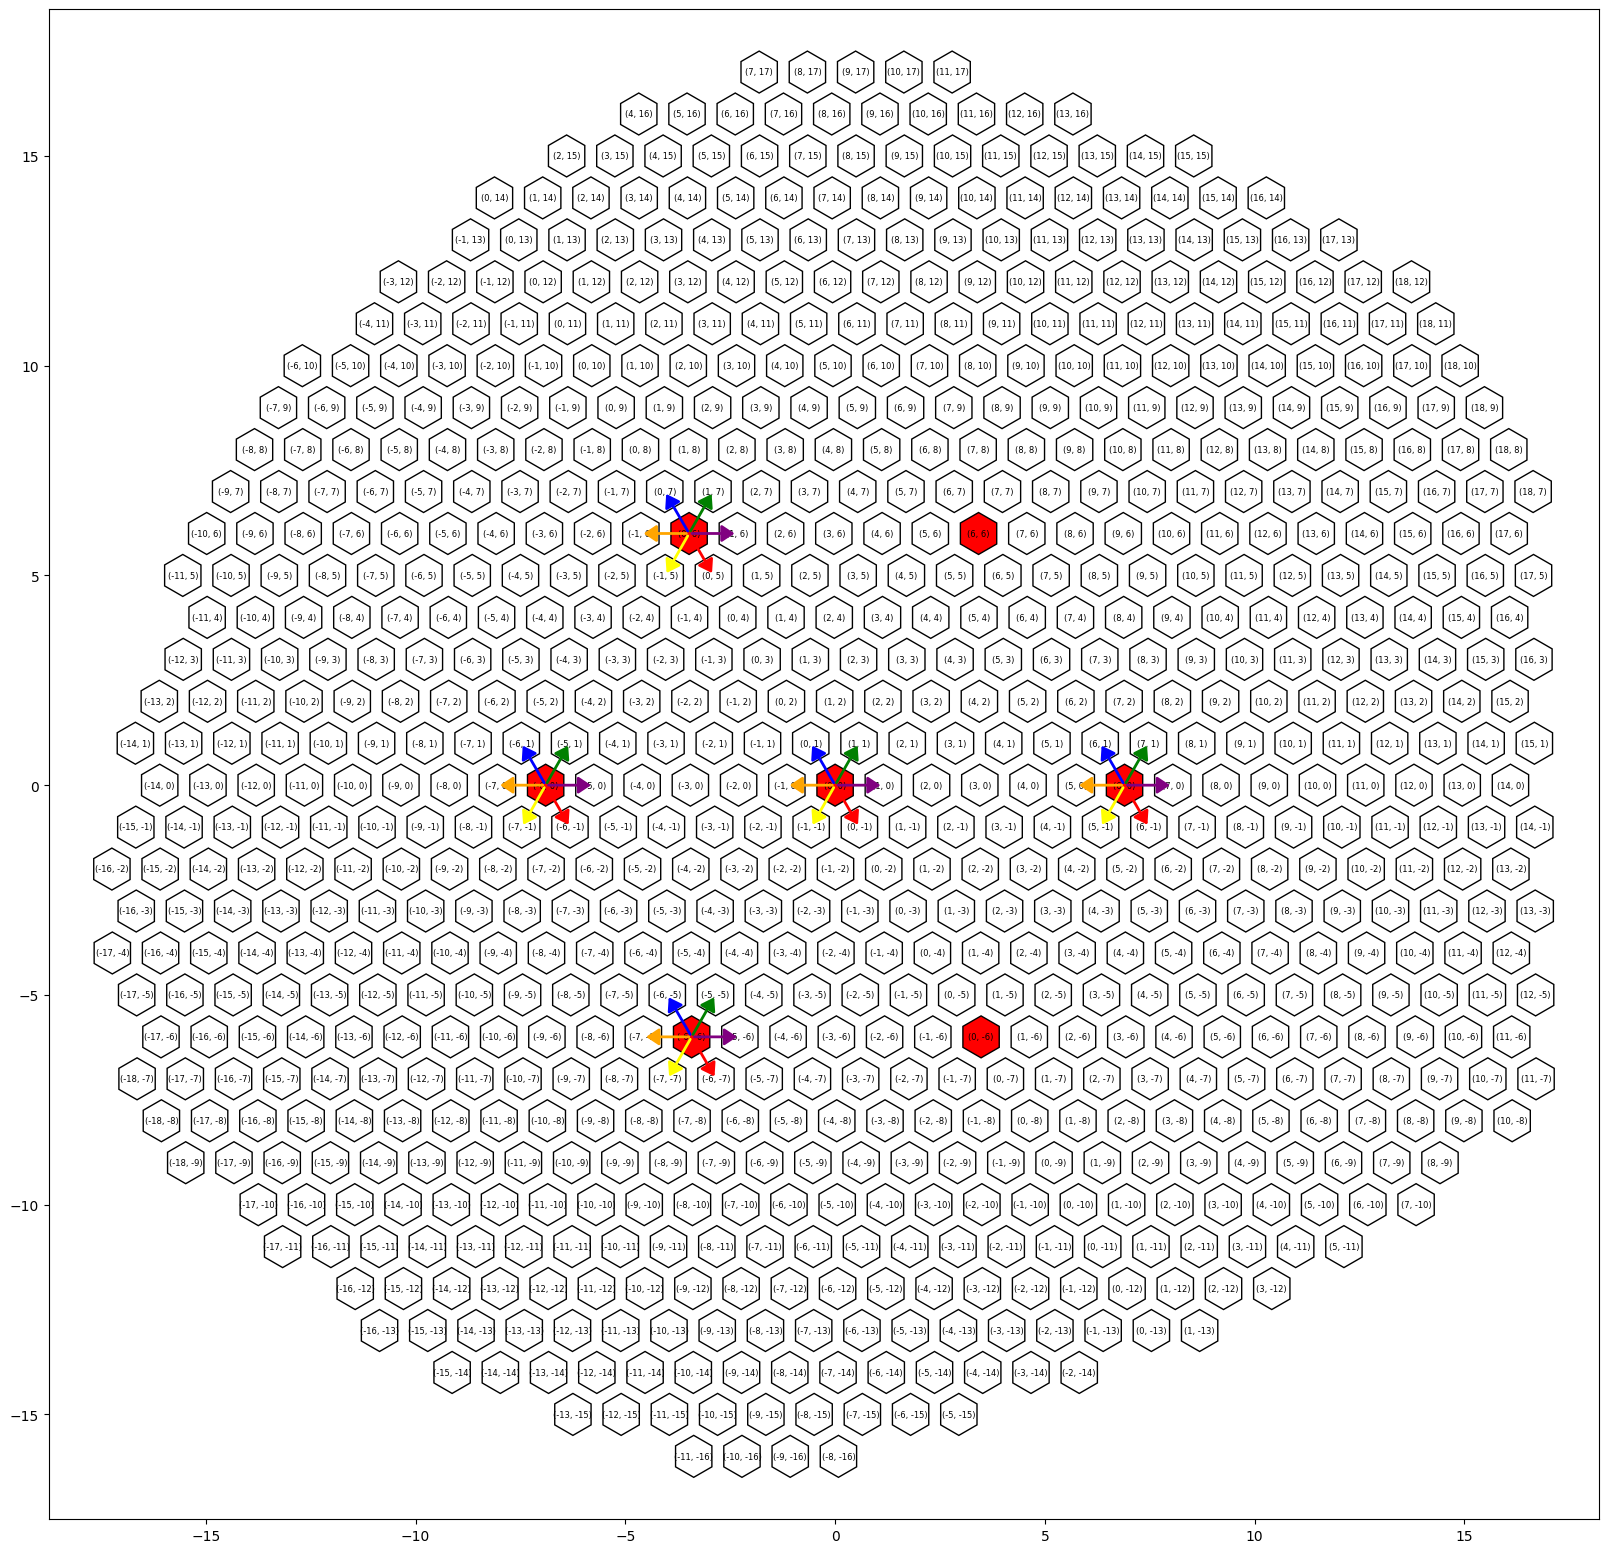

In [175]:

# Data
new_p_values = new_centered_p_values

## Plotting on the 2D lattice: check access to each point and axis
fig, ax, hexagons = plot_hex_grid(new_p_values, original_q, hex_size=0.5, spacing=1.0, fig_size=(20, 20), labels=labels, label_type='manual_labels', text_size=6)

# Example to color hexagons based on a condition

color_in_p = 0
color_in_p = add_space_in_between(18, 18, _space, [color_in_p])
color_in_p = color_in_p[0]
color_in_q = 0
for hexagon, (x_pos, y_pos) in zip(hexagons, zip(new_p_values, original_q)):
    new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=_relative_change) - center_shift # dealing with shifts
    if x_pos == new_p_pos[0] and y_pos == color_in_q:
        hexagon.set_facecolor('red')

color_in_p = 0
color_in_p = add_space_in_between(18, 18, _space, [color_in_p])
color_in_p = color_in_p[0]
color_in_q = 6
for hexagon, (x_pos, y_pos) in zip(hexagons, zip(new_p_values, original_q)):
    new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=_relative_change) - center_shift# dealing with shifts
    if x_pos == new_p_pos[0] and y_pos == color_in_q:
        hexagon.set_facecolor('red')

color_in_p = 0
color_in_p = add_space_in_between(18, 18, _space, [color_in_p])
color_in_p = color_in_p[0]
color_in_q = -6
for hexagon, (x_pos, y_pos) in zip(hexagons, zip(new_p_values, original_q)):
    new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=_relative_change) - center_shift # dealing with shifts
    if x_pos == new_p_pos[0] and y_pos == color_in_q:
        hexagon.set_facecolor('red')

color_in_p = 6
color_in_p = add_space_in_between(18, 18, _space, [color_in_p])
color_in_p = color_in_p[0]
color_in_q = 0
for hexagon, (x_pos, y_pos) in zip(hexagons, zip(new_p_values, original_q)):
    new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=_relative_change) - center_shift # dealing with shifts
    if x_pos == new_p_pos[0] and y_pos == color_in_q:
        hexagon.set_facecolor('red')

color_in_p = -6
color_in_p = add_space_in_between(18, 18, _space, [color_in_p])
color_in_p = color_in_p[0]
color_in_q = 0
for hexagon, (x_pos, y_pos) in zip(hexagons, zip(new_p_values, original_q)):
    new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=_relative_change) - center_shift # dealing with shifts
    if x_pos == new_p_pos[0] and y_pos == color_in_q:
        hexagon.set_facecolor('red')

color_in_p = 6
color_in_p = add_space_in_between(18, 18, _space, [color_in_p])
color_in_p = color_in_p[0]
color_in_q = 6
for hexagon, (x_pos, y_pos) in zip(hexagons, zip(new_p_values, original_q)):
    new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=_relative_change) - center_shift # dealing with shifts
    if x_pos == new_p_pos[0] and y_pos == color_in_q:
        hexagon.set_facecolor('red')

color_in_p = -6
color_in_p = add_space_in_between(18, 18, _space, [color_in_p])
color_in_p = color_in_p[0]
color_in_q = -6
for hexagon, (x_pos, y_pos) in zip(hexagons, zip(new_p_values, original_q)):
    new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=_relative_change) - center_shift # dealing with shifts
    if x_pos == new_p_pos[0] and y_pos == color_in_q:
        hexagon.set_facecolor('red')

# Draw vector from hexagon to hexagon
# Choose column_ids
start_ids = ([628]*6) + ([546]*6) + ([732]*6) + ([382]*6) + ([199]*6)
end_ids = [120, 486, 747,38,250,627] + [673,306,140,536,528,768] + [90,434,654,263,392,206] + [483,158,213,416,77,678] + [754,656,526,571,191,129]
color_ls = ["red", "blue", "green", "yellow", "purple", "orange"]*5
start_coords_ls = []
end_coords_ls = []
for start_id, end_id in zip(start_ids, end_ids):
    start_id_p = df_grid[df_grid.column_id == str(start_id)].new_centered_p.values[0]
    start_id_q = df_grid[df_grid.column_id == str(start_id)].q.values[0]
    start_coords_ls.append((start_id_p,start_id_q))

    
    end_id_p = df_grid[df_grid.column_id == str(end_id)].new_centered_p.values[0]
    end_id_q = df_grid[df_grid.column_id == str(end_id)].q.values[0]
    end_coords_ls.append((end_id_p,end_id_q))

    #Drawing vectors
i = 0
for start_coord, end_coord in zip(start_coords_ls,end_coords_ls):
    # Find the coordinates of the start and end hexagons
    x_start = start_coord[0]
    y_start = start_coord[1]
    
    x_end = end_coord[0]
    y_end = end_coord[1]

    draw_vector(ax, x_start, y_start, x_end, y_end, color=color_ls[i])
    #print(f'Color: {color_ls[i]}, end: ({x_end},{y_end})')
    i += 1
    


plt.show()

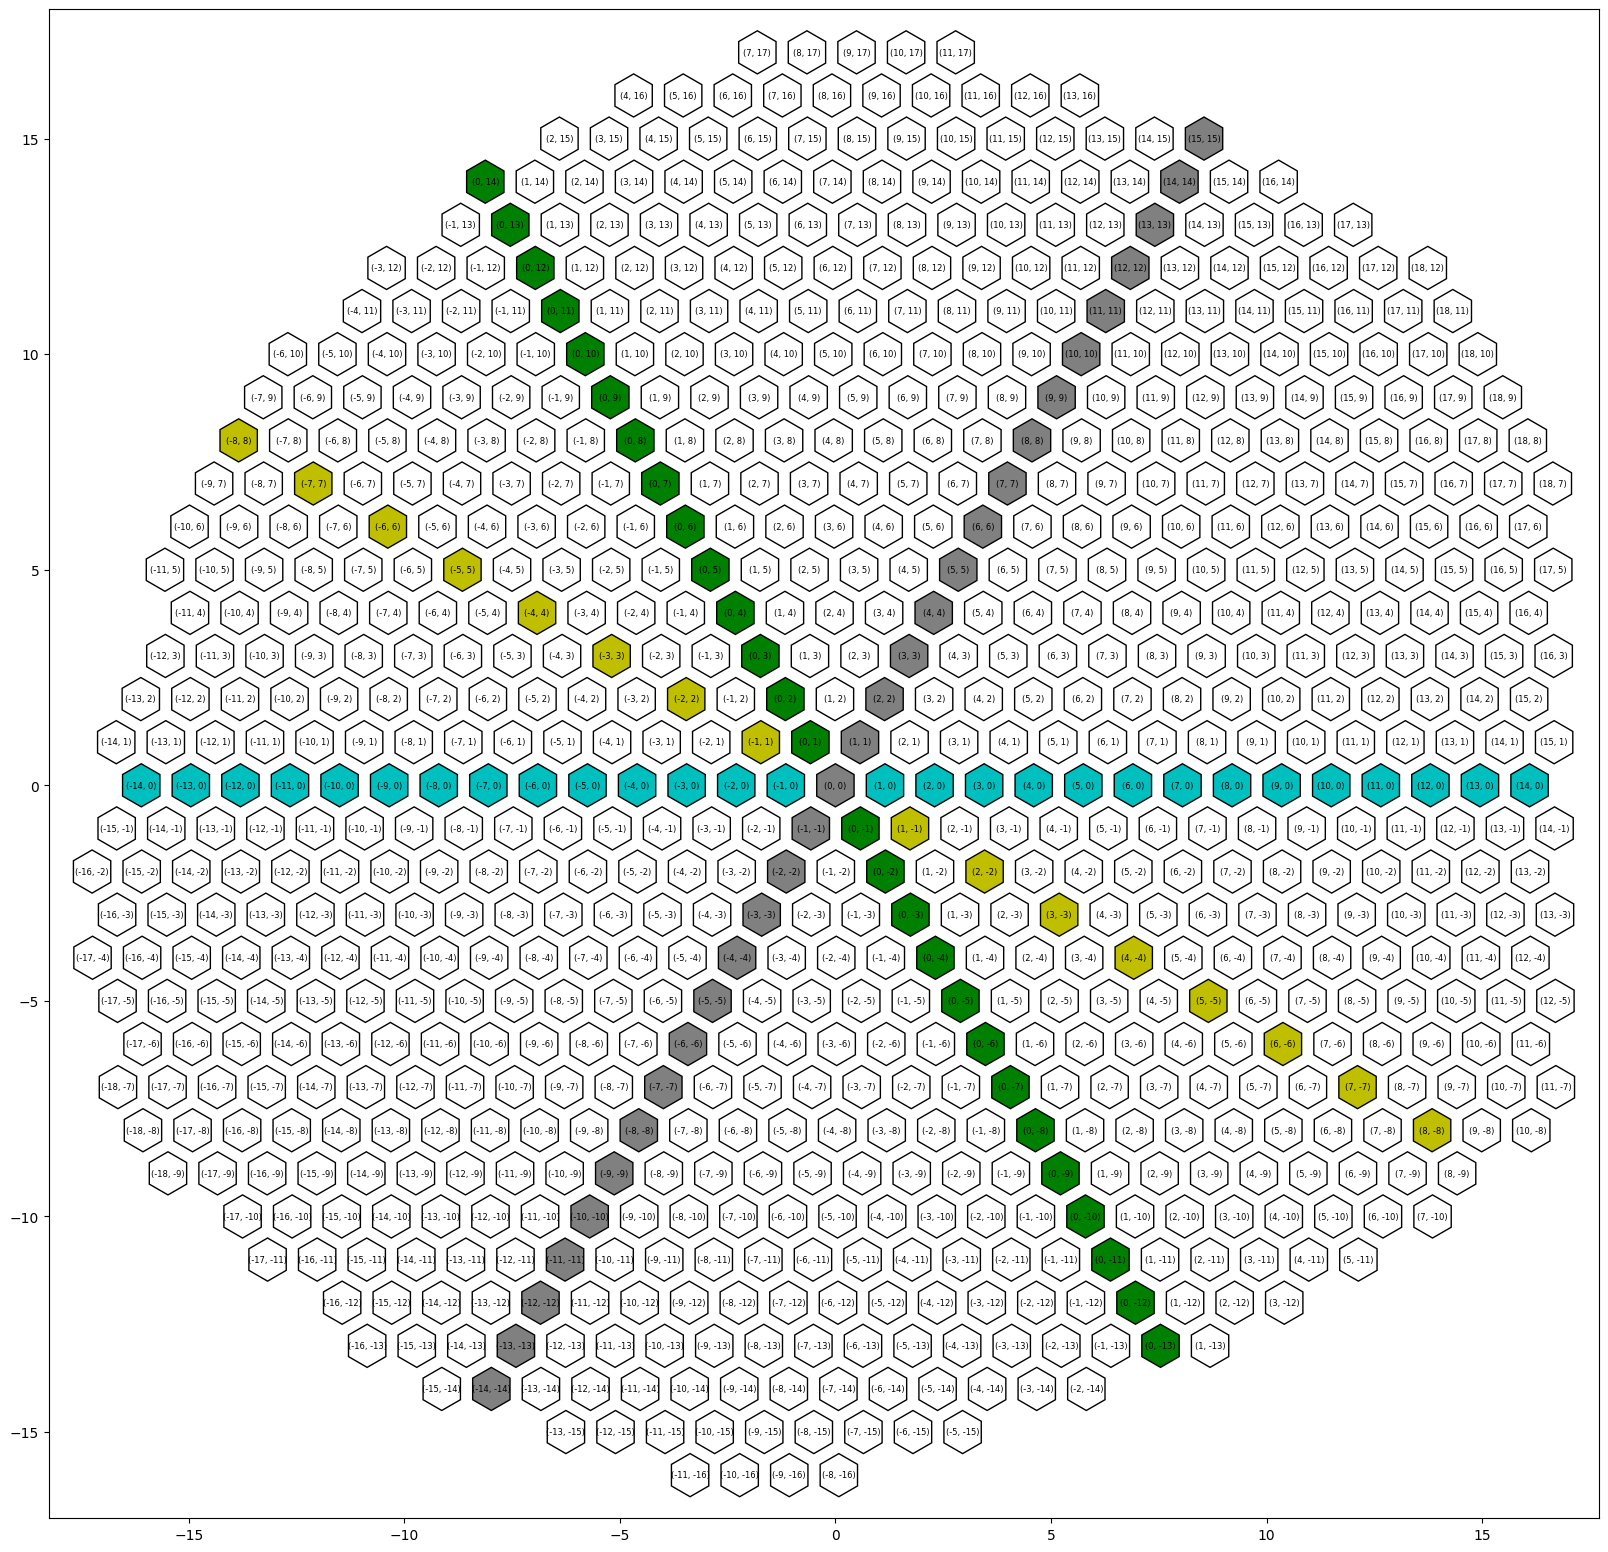

In [176]:
## Plotting on the 2D lattice: look at the reference axis (h, v, p, q) 
fig, ax, hexagons = plot_hex_grid(new_p_values, original_q, hex_size=0.5, spacing=0.5, fig_size=(20, 20), labels=labels, label_type='manual_labels', text_size=6)

# Example to color hexagons based on a condition
new_p_x_ls = []
for p_x, p_y in p:
    color_in_p = p_x
    color_in_p = add_space_in_between(18, 18, _space, [color_in_p])
    color_in_p = color_in_p[0]
    color_in_q = p_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(new_p_values, original_q)):
        new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=_relative_change)  - center_shift# dealing with shifts
        if x_pos == new_p_pos[0] and y_pos == color_in_q:
            hexagon.set_facecolor('g')
            new_p_x_ls.append(new_p_pos[0])
            
new_q_x_ls = []
for q_x, q_y in q:
    color_in_p = q_x
    color_in_p = add_space_in_between(18, 18, _space, [color_in_p])
    color_in_p = color_in_p[0]
    color_in_q = q_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(new_p_values, original_q)):
        new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=_relative_change) - center_shift # dealing with shifts
        if x_pos == new_p_pos[0] and y_pos == color_in_q:
            hexagon.set_facecolor('c')
            new_q_x_ls.append(new_p_pos[0])
            
new_h_x_ls = []
for h_x, h_y in h:
    color_in_p = h_x
    color_in_p = add_space_in_between(18, 18, _space, [color_in_p])
    color_in_p = color_in_p[0]
    color_in_q = h_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(new_p_values, original_q)):
        new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=_relative_change) - center_shift # dealing with shifts
        if x_pos == new_p_pos[0] and y_pos == color_in_q:
            hexagon.set_facecolor('y')
            new_h_x_ls.append(new_p_pos[0])

new_v_x_ls = []
for v_x, v_y in v:
    color_in_p = v_x
    color_in_p = add_space_in_between(18, 18, _space, [color_in_p])
    color_in_p = color_in_p[0]
    color_in_q = v_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(new_p_values, original_q)):
        new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=_relative_change) - center_shift # dealing with shifts
        if x_pos == new_p_pos[0] and y_pos == color_in_q:
            hexagon.set_facecolor('grey')
            new_v_x_ls.append(new_p_pos[0])
            

plt.show()

# 4. Plotting optic flow data on the grid/lattice

The logic is to obtain:
1) the home column based on column_id assignment, 
2) the column_id of the highly connected intracolumnar input cells via absolute synaptic counts
3) draw vectors to/from home column from/to those input-cell columns

In [177]:
## Be aware that these two initial data frames do not have the same unique IDs
## Ideally they should. Think of replacing the one that has less

print(f'"ol_connections" df length: {len(ol_connections.to_cell_id.unique())}')
print(f'"columns_id_data" df length: {len(columns_id_data.root_id.unique())}')

"ol_connections" df length: 22824
"columns_id_data" df length: 23452


In [178]:
## Ploting setting

color_dict = {'T4a':'g','T4b':'b', 'T4c':'r', 'T4d':'y'}
correlator = 'HR-BL' # 'BL' for Barlow-Levick, 'HR' for Hassenstein-Reichert, 'HR-BL' for the combination
to_cell_of_interest = 'T4d'

In [179]:
## Getting inputs of the cell of interest implementing the BL correlator
BL_cell_of_interest = 'Mi4'

cell_of_interest_inputs = ol_connections_extended[(ol_connections_extended.to_cell_type == to_cell_of_interest) & (ol_connections_extended.from_cell_type == BL_cell_of_interest)].copy()
num_of_cells = len(cell_of_interest_inputs[cell_of_interest_inputs.to_cell_type == to_cell_of_interest].to_cell_id.unique())
num_of_columns = len(cell_of_interest_inputs[cell_of_interest_inputs.to_cell_type == to_cell_of_interest].to_column_id.unique())
print(f'Number of unique postsynaptic cells / columns of interest: {num_of_cells} / {num_of_columns}')

# Sort by to_cell_id and synapses in descending order
cell_of_interest_inputs_sorted = cell_of_interest_inputs.sort_values(by=['to_cell_id', 'synapses'], ascending=[True, False])

# Group by to_cell_id and take the first row for each group (highest synapse value)
BL_unique_highest_inputs = cell_of_interest_inputs_sorted.drop_duplicates(subset='to_cell_id', keep='first').copy()

#Dropping 'not assigned' rows
BL_unique_highest_inputs_filtered = BL_unique_highest_inputs[BL_unique_highest_inputs.to_column_id != 'not assigned'].copy()

# Find the duplicates with the same to_cell_id and synapse value
BL_duplicates_in_highest_inputs = cell_of_interest_inputs_sorted[cell_of_interest_inputs_sorted.duplicated(subset=['to_cell_id', 'synapses'], keep=False)]

# Changing column names for clarity
BL_unique_highest_inputs_filtered.rename(columns={'from_cell_id': 'BL_cell_id', 'from_cell_type': 'BL_cell_type', 'from_column_id': 'BL_column_id', 
                                                  'to_cell_id': 'home_cell_id', 'to_cell_type': 'home_cell_type','to_column_id': 'home_column_id','synapses' :'BL_synapses'},inplace = True)
# Comvertions to strings
BL_unique_highest_inputs_filtered['BL_cell_id'] = BL_unique_highest_inputs_filtered['BL_cell_id'].apply(str)


# Display the resulting data frames
print("\nUnique Highest Inputs:")
display(BL_unique_highest_inputs_filtered.head())
print(f'\n"BL_unique_highest_inputs" df length: {len(BL_unique_highest_inputs_filtered)}')



#print("\nDuplicates in Highest Inputs:")
#print(BL_duplicates_in_highest_inputs.head())
#print(len(BL_duplicates_in_highest_inputs))

Number of unique postsynaptic cells / columns of interest: 619 / 595

Unique Highest Inputs:


BL_cell_id        home_cell_id  BL_synapses BL_cell_type  \
35921   720575940613839986  720575940600934665            3          Mi4   
200673  720575940631230275  720575940603498357           10          Mi4   
242138  720575940637856996  720575940603556981           11          Mi4   
210681  720575940632347463  720575940603842476            2          Mi4   
100643  720575940621800630  720575940604436720            3          Mi4   

       BL_column_id home_cell_type home_column_id  
35921           591            T4d            203  
200673          635            T4d            219  
242138          521            T4d            268  
210681          717            T4d             83  
100643          142            T4d            142


"BL_unique_highest_inputs" df length: 594


In [180]:
## Getting inputs of the cell of interest implementing the HR correlator
HR_cell_of_interest = 'Mi9'

cell_of_interest_inputs = ol_connections_extended[(ol_connections_extended.to_cell_type == to_cell_of_interest) & (ol_connections_extended.from_cell_type == HR_cell_of_interest)].copy()
num_of_cells = len(cell_of_interest_inputs[cell_of_interest_inputs.to_cell_type == to_cell_of_interest].to_cell_id.unique())
num_of_columns = len(cell_of_interest_inputs[cell_of_interest_inputs.to_cell_type == to_cell_of_interest].to_column_id.unique())
print(f'Number of unique postsynaptic cells / columns of interest: {num_of_cells} / {num_of_columns}')

# Sort by to_cell_id and synapses in descending order
cell_of_interest_inputs_sorted = cell_of_interest_inputs.sort_values(by=['to_cell_id', 'synapses'], ascending=[True, False])

# Group by to_cell_id and take the first row for each group (highest synapse value)
HR_unique_highest_inputs = cell_of_interest_inputs_sorted.drop_duplicates(subset='to_cell_id', keep='first')

#Dropping 'not assigned' rows
HR_unique_highest_inputs_filtered = HR_unique_highest_inputs[HR_unique_highest_inputs.to_column_id != 'not assigned'].copy()

# Find the duplicates with the same to_cell_id and synapse value
HR_duplicates_in_highest_inputs = cell_of_interest_inputs_sorted[cell_of_interest_inputs_sorted.duplicated(subset=['to_cell_id', 'synapses'], keep=False)]

# Changing column names for clarity
HR_unique_highest_inputs_filtered.rename(columns={'from_cell_id': 'HR_cell_id', 'from_cell_type': 'HR_cell_type', 'from_column_id': 'HR_column_id', 
                                                  'to_cell_id': 'home_cell_id', 'to_cell_type': 'home_cell_type','to_column_id': 'home_column_id','synapses' :'HR_synapses'}, inplace = True)
# Comvertions to strings
HR_unique_highest_inputs_filtered['HR_cell_id'] = HR_unique_highest_inputs_filtered['HR_cell_id'].apply(str)


# Display the resulting data frames
print("\nUnique Highest Inputs:")
display(HR_unique_highest_inputs_filtered.head())
print(f'\n"HR_unique_highest_inputs" df length: {len(HR_unique_highest_inputs_filtered)}')

#print("\nDuplicates in Highest Inputs:")
#print(HR_duplicates_in_highest_inputs.head())
#print(len(HR_duplicates_in_highest_inputs))

Number of unique postsynaptic cells / columns of interest: 697 / 670

Unique Highest Inputs:


HR_cell_id        home_cell_id  HR_synapses HR_cell_type  \
126340  720575940624215221  720575940600934665            5          Mi9   
108049  720575940622527871  720575940603356896            2          Mi9   
26334   720575940612188017  720575940603498357           11          Mi9   
206142  720575940631840587  720575940603556981            9          Mi9   
113669  720575940623102600  720575940603842476            6          Mi9   

       HR_column_id home_cell_type home_column_id  
126340          118            T4d            203  
108049          650            T4d            354  
26334            81            T4d            219  
206142          371            T4d            268  
113669          269            T4d             83


"HR_unique_highest_inputs" df length: 669


In [181]:
## Combining the two correlators

# Merge data frames of both correlators (with inner join to keep only the rows with keys that are present in both DataFrames)
HR_BL_unique_highest_inputs_filtered = BL_unique_highest_inputs_filtered.merge(
    HR_unique_highest_inputs_filtered[['HR_cell_id', 'HR_cell_type','HR_synapses','HR_column_id','home_cell_id']],
    how='inner',
    left_on='home_cell_id',
    right_on='home_cell_id'
)

#Dropping 'not assigned' rows
HR_BL_unique_highest_inputs_filtered = HR_BL_unique_highest_inputs_filtered[HR_BL_unique_highest_inputs_filtered.BL_column_id != 'not assigned'].copy()
HR_BL_unique_highest_inputs_filtered = HR_BL_unique_highest_inputs_filtered[HR_BL_unique_highest_inputs_filtered.HR_column_id != 'not assigned'].copy()


# Display the resulting data frames
print("\nUnique Highest Inputs:")
display(HR_BL_unique_highest_inputs_filtered.head())
print(f'\n"HR_BL_unique_highest_inputs_filtered" df length: {len(HR_BL_unique_highest_inputs_filtered)}')


Unique Highest Inputs:


BL_cell_id        home_cell_id  BL_synapses BL_cell_type  \
0  720575940613839986  720575940600934665            3          Mi4   
1  720575940631230275  720575940603498357           10          Mi4   
2  720575940637856996  720575940603556981           11          Mi4   
3  720575940632347463  720575940603842476            2          Mi4   
4  720575940621800630  720575940604436720            3          Mi4   

  BL_column_id home_cell_type home_column_id          HR_cell_id HR_cell_type  \
0          591            T4d            203  720575940624215221          Mi9   
1          635            T4d            219  720575940612188017          Mi9   
2          521            T4d            268  720575940631840587          Mi9   
3          717            T4d             83  720575940623102600          Mi9   
4          142            T4d            142  720575940635423386          Mi9   

   HR_synapses HR_column_id  
0            5          118  
1           11           81  
2            9          371  
3            6          269  
4            3          474


"HR_BL_unique_highest_inputs_filtered" df length: 541


In [182]:
## Preparing grid to plot

# Given coordinates and labels (data)
# Original coordinates
original_p = df_grid.p.tolist()
original_q = df_grid.q.tolist()

# Adjusting p values to get a honeycomb-like grid
# Shifting and spacing x coordinates
_relative_change = 0.58
_space = 1.15
spaced_original_p  = add_space_in_between(18, 18, _space, original_p)
new_p_values = calculate_new_p_values(spaced_original_p, original_q, start_key=-16, end_key=17, relative_change=_relative_change, in_space=_space)
df_grid['new_p'] = new_p_values
center_shift = df_grid[df_grid.column_id == '628'].new_p.values[0] # Centering the original (0,0) coordinate again to 0,0
new_centered_p_values = new_p_values  - center_shift
df_grid['new_centered_p'] = new_centered_p_values
# "manual_labels" column ids
labels = df_grid.column_id.tolist() 
#labels = None



## 4.1. Honeycomb-like grid

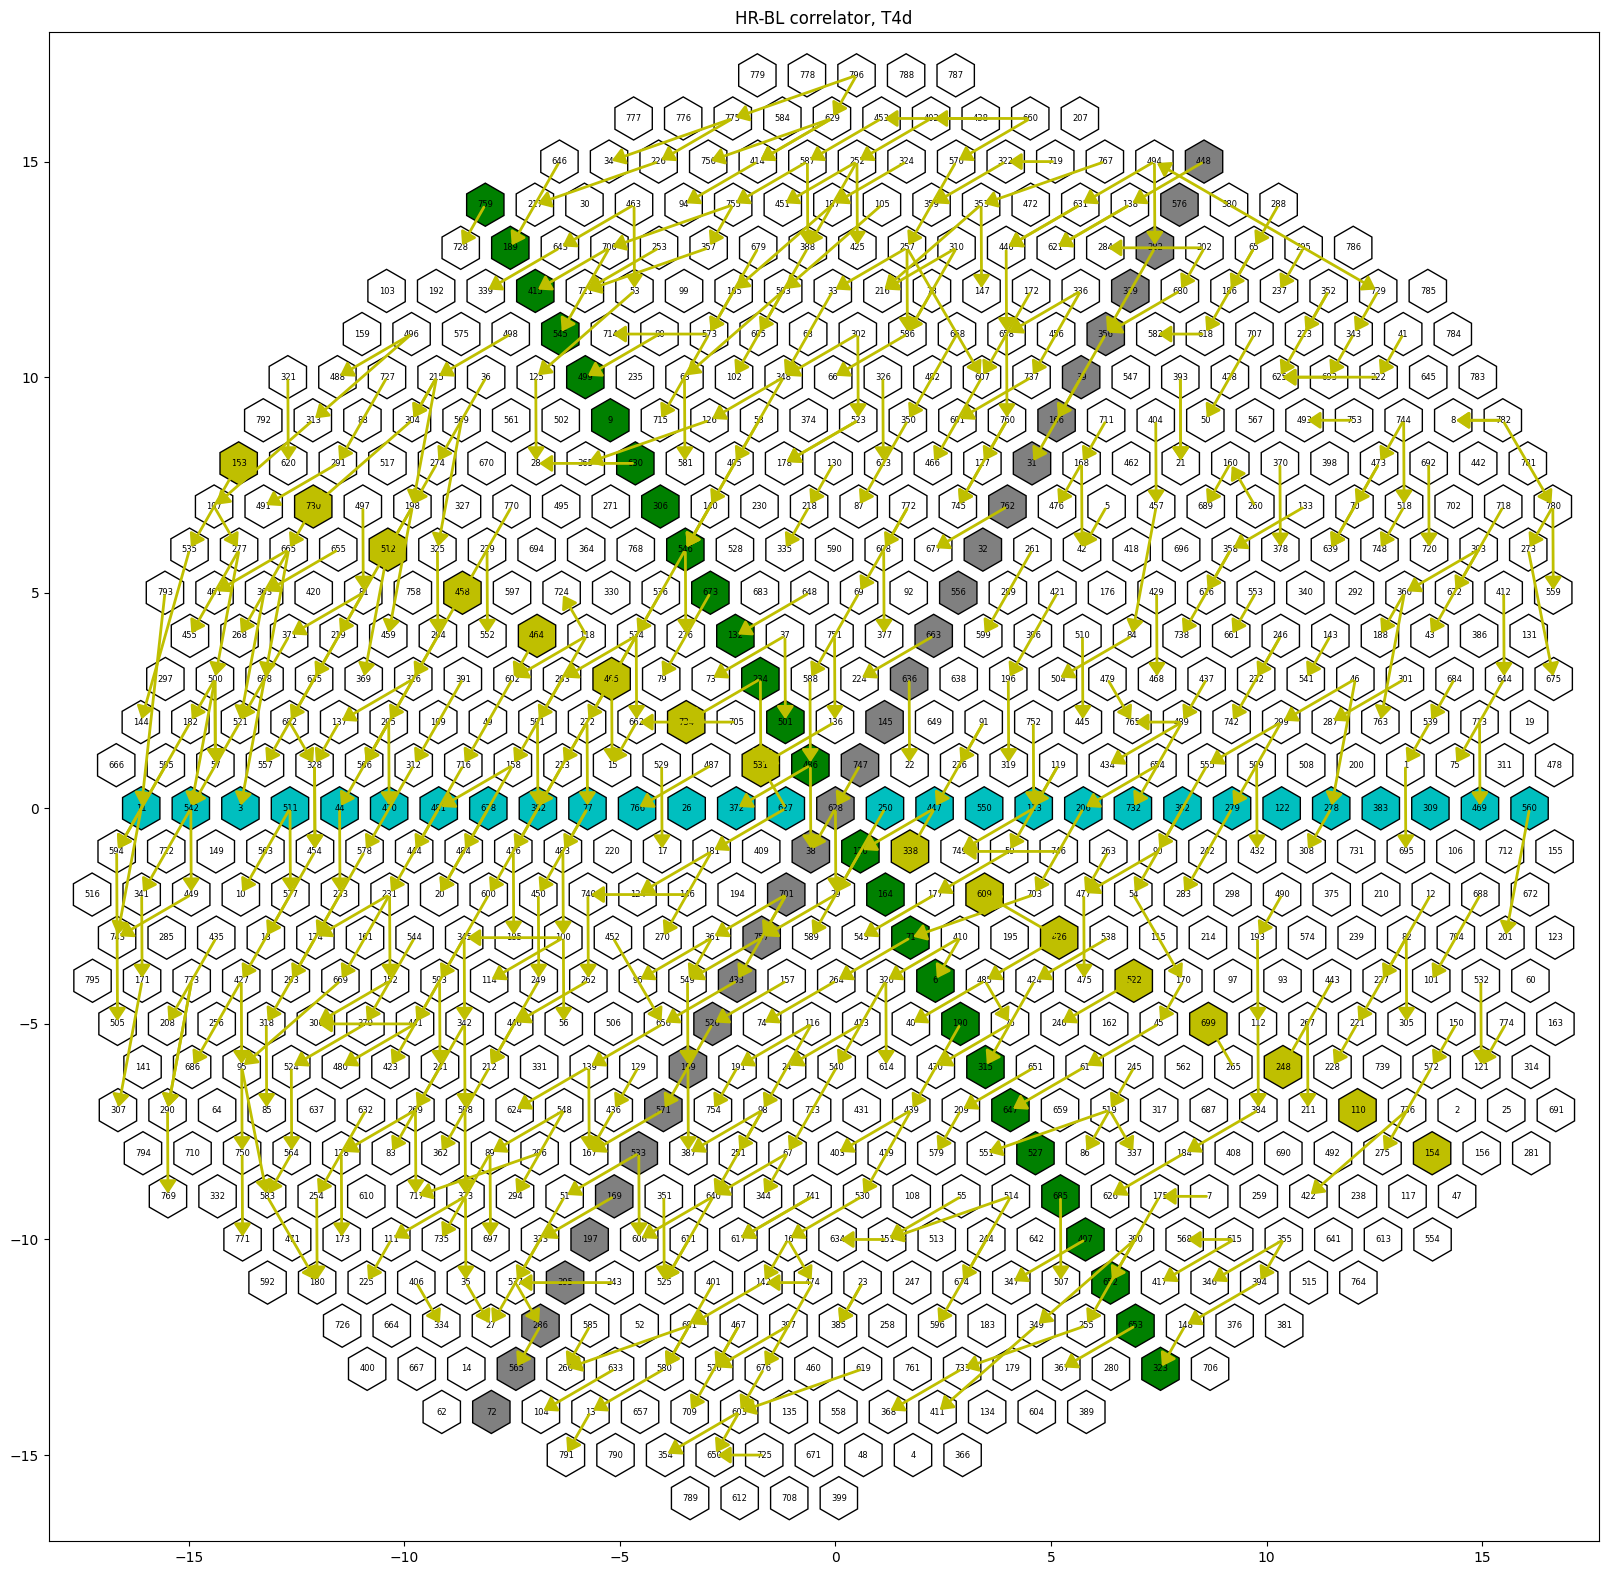

In [183]:
## Plotting on the 2D lattice: look at the reference axis (h, v, p, q) 
new_p_values = new_centered_p_values
fig, ax, hexagons = plot_hex_grid(new_p_values, original_q, hex_size=0.5, spacing=0.5, fig_size=(20, 20), labels=labels, label_type='manual_labels', text_size=6)

# Example to color hexagons based on a condition
new_p_x_ls = []
for p_x, p_y in p:
    color_in_p = p_x
    color_in_p = add_space_in_between(18, 18, _space, [color_in_p])
    color_in_p = color_in_p[0]
    color_in_q = p_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(new_p_values, original_q)):
        new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=_relative_change)  - center_shift# dealing with shifts
        if x_pos == new_p_pos[0] and y_pos == color_in_q:
            hexagon.set_facecolor('g')
            new_p_x_ls.append(new_p_pos[0])
            
new_q_x_ls = []
for q_x, q_y in q:
    color_in_p = q_x
    color_in_p = add_space_in_between(18, 18, _space, [color_in_p])
    color_in_p = color_in_p[0]
    color_in_q = q_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(new_p_values, original_q)):
        new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=_relative_change)  - center_shift# dealing with shifts
        if x_pos == new_p_pos[0] and y_pos == color_in_q:
            hexagon.set_facecolor('c')
            new_q_x_ls.append(new_p_pos[0])
            
new_h_x_ls = []
for h_x, h_y in h:
    color_in_p = h_x
    color_in_p = add_space_in_between(18, 18, _space, [color_in_p])
    color_in_p = color_in_p[0]
    color_in_q = h_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(new_p_values, original_q)):
        new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=_relative_change)  - center_shift# dealing with shifts
        if x_pos == new_p_pos[0] and y_pos == color_in_q:
            hexagon.set_facecolor('y')
            new_h_x_ls.append(new_p_pos[0])

new_v_x_ls = []
for v_x, v_y in v:
    color_in_p = v_x
    color_in_p = add_space_in_between(18, 18, _space, [color_in_p])
    color_in_p = color_in_p[0]
    color_in_q = v_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(new_p_values, original_q)):
        new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=_relative_change) - center_shift # dealing with shifts
        if x_pos == new_p_pos[0] and y_pos == color_in_q:
            hexagon.set_facecolor('grey')
            new_v_x_ls.append(new_p_pos[0])


new_180_0_deg_axis = list(zip(new_h_x_ls,h_y_ls)) # This is my reference line to calculate vectors angles. (currently used. It is the eye´s equator)
new_270_90_deg_axis = list(zip(new_v_x_ls,v_y_ls)) # This is my reference line to calculate vectors angles. (currently NOT used. It is the perpendicular line to the eye´s equator)

# Draw vector from hexagon to hexagon
# Savecolumn_ids (start and end) based on the expected preferred direction (PD) for all correlators of a list


corr_ls = ['BL', 'HR', 'HR-BL']
for corr_i in corr_ls:

    if corr_i == 'BL':
        start_ids = [int(x) for x in HR_BL_unique_highest_inputs_filtered.home_column_id.tolist()]
        end_ids = [int(x) for x in HR_BL_unique_highest_inputs_filtered.BL_column_id.tolist()] 
    elif corr_i == 'HR':
        start_ids = [int(x) for x in HR_BL_unique_highest_inputs_filtered.HR_column_id.tolist()]
        end_ids = [int(x) for x in HR_BL_unique_highest_inputs_filtered.home_column_id.tolist()]  
    elif corr_i == 'HR-BL':
        start_ids = [int(x) for x in HR_BL_unique_highest_inputs_filtered.HR_column_id.tolist()]
        end_ids = [int(x) for x in HR_BL_unique_highest_inputs_filtered.BL_column_id.tolist()]  

    #Getting vector coordinates    
    start_coords_ls = []
    end_coords_ls = []
    for start_id, end_id in zip(start_ids, end_ids):
        start_id_p = df_grid[df_grid.column_id == str(start_id)].new_centered_p.values[0]
        start_id_q = df_grid[df_grid.column_id == str(start_id)].q.values[0]
        start_coords_ls.append((start_id_p,start_id_q))
    
        
        end_id_p = df_grid[df_grid.column_id == str(end_id)].new_centered_p.values[0]
        end_id_q = df_grid[df_grid.column_id == str(end_id)].q.values[0]
        end_coords_ls.append((end_id_p,end_id_q))
    
    #Saving coordinates in the main data frame
    str_start_coords = f'{corr_i}_start_coords'
    str_end_coords = f'{corr_i}_end_coords'
    HR_BL_unique_highest_inputs_filtered[str_start_coords] = start_coords_ls
    HR_BL_unique_highest_inputs_filtered[str_end_coords] = end_coords_ls

#Saving start and end IDs for BL, HR and HR-BL
HR_BL_unique_highest_inputs_filtered['BL_start_ids'] = [int(x) for x in HR_BL_unique_highest_inputs_filtered.home_column_id.tolist()]
HR_BL_unique_highest_inputs_filtered['BL_end_ids'] = [int(x) for x in HR_BL_unique_highest_inputs_filtered.BL_column_id.tolist()] 

HR_BL_unique_highest_inputs_filtered['HR_start_ids'] = [int(x) for x in HR_BL_unique_highest_inputs_filtered.HR_column_id.tolist()]
HR_BL_unique_highest_inputs_filtered['HR_end_ids'] = [int(x) for x in HR_BL_unique_highest_inputs_filtered.home_column_id.tolist()]  

HR_BL_unique_highest_inputs_filtered['HR-BL_start_ids'] = [int(x) for x in HR_BL_unique_highest_inputs_filtered.HR_column_id.tolist()]
HR_BL_unique_highest_inputs_filtered['HR-BL_end_ids'] = [int(x) for x in HR_BL_unique_highest_inputs_filtered.BL_column_id.tolist()]  



#Drawing vectors of a specific correlator
if corr_i == 'BL':
    start_coords_ls = HR_BL_unique_highest_inputs_filtered['BL_start_coords']
    end_coords_ls = HR_BL_unique_highest_inputs_filtered['BL_end_coords']
elif corr_i == 'HR':
    start_coords_ls = HR_BL_unique_highest_inputs_filtered['HR_start_coords']
    end_coords_ls = HR_BL_unique_highest_inputs_filtered['HR_end_coords']
elif corr_i == 'HR-BL':
    start_coords_ls = HR_BL_unique_highest_inputs_filtered['HR-BL_start_coords']
    end_coords_ls = HR_BL_unique_highest_inputs_filtered['HR-BL_end_coords']
    
for start_coord, end_coord in zip(start_coords_ls,end_coords_ls):
    # Find the coordinates of the start and end hexagons
    x_start = start_coord[0]
    y_start = start_coord[1]
    
    x_end = end_coord[0]
    y_end = end_coord[1]

    draw_vector(ax, x_start, y_start, x_end, y_end, color=color_dict[to_cell_of_interest])

plt.title(f'{correlator} correlator, {to_cell_of_interest}')
plt.show()

In [184]:
HR_BL_unique_highest_inputs_filtered.head()

BL_cell_id        home_cell_id  BL_synapses BL_cell_type  \
0  720575940613839986  720575940600934665            3          Mi4   
1  720575940631230275  720575940603498357           10          Mi4   
2  720575940637856996  720575940603556981           11          Mi4   
3  720575940632347463  720575940603842476            2          Mi4   
4  720575940621800630  720575940604436720            3          Mi4   

  BL_column_id home_cell_type home_column_id          HR_cell_id HR_cell_type  \
0          591            T4d            203  720575940624215221          Mi9   
1          635            T4d            219  720575940612188017          Mi9   
2          521            T4d            268  720575940631840587          Mi9   
3          717            T4d             83  720575940623102600          Mi9   
4          142            T4d            142  720575940635423386          Mi9   

   HR_synapses  ...             HR_start_coords             HR_end_coords  \
0            5  ...                  (-5.77, 4)                (-6.34, 3)   
1           11  ...    (-10.949999999999998, 5)  (-11.519999999999998, 4)   
2            9  ...                 (-12.67, 4)  (-13.820000000000002, 4)   
3            6  ...                 (-9.74, -7)              (-10.31, -8)   
4            3  ...  (-0.5199999999999996, -11)              (-1.67, -11)   

           HR-BL_start_coords          HR-BL_end_coords BL_start_ids  \
0                  (-5.77, 4)   (-6.909999999999998, 2)          203   
1    (-10.949999999999998, 5)  (-12.089999999999998, 3)          219   
2                 (-12.67, 4)  (-13.809999999999997, 2)          268   
3                 (-9.74, -7)  (-9.729999999999999, -9)           83   
4  (-0.5199999999999996, -11)              (-1.67, -11)          142   

  BL_end_ids HR_start_ids  HR_end_ids  HR-BL_start_ids  HR-BL_end_ids  
0        591          118         203              118            591  
1        635           81         219               81            635  
2        521          371         268              371            521  
3        717          269          83              269            717  
4        142          474         142              474            142  

[5 rows x 23 columns]

In [185]:
## Defining the reference line to which calculate the angles of the drawn vectors
# new_180_0_deg_axis is the equator line once the x coordinates have been shifted to fit the honeycomb-like grid

# Given points defining the new line
points = new_180_0_deg_axis

# Calculate the slope (m) and angle of the new line
x1, y1 = points[0]
x2, y2 = points[-1]
slope = (y2 - y1) / (x2 - x1)
reference_angle_rad = np.arctan(slope)

# Prepare the list for angles
angles = []

# Calculate the angle for each vector
start_ids = HR_BL_unique_highest_inputs_filtered[f'{correlator}_start_ids'].tolist()
end_ids = HR_BL_unique_highest_inputs_filtered[f'{correlator}_end_ids'].tolist()
start_coords_ls = HR_BL_unique_highest_inputs_filtered[f'{correlator}_start_coords'].tolist()
end_coords_ls = HR_BL_unique_highest_inputs_filtered[f'{correlator}_end_coords'].tolist()

for start_id, end_id, start_coord, end_coord in zip(start_ids, end_ids, start_coords_ls, end_coords_ls):
    # Coordinates
    x_start, y_start = start_coord
    x_end, y_end = end_coord
    
    # Calculate the change in coordinates
    dx = x_end - x_start
    dy = y_end - y_start
    
    # Calculate the angle in radians relative to the x-axis
    angle_rad = np.arctan2(dy, dx)
    
    # Adjust the angle relative to the new reference line
    adjusted_angle_rad = angle_rad - reference_angle_rad
    
    # Convert to degrees
    adjusted_angle_deg = np.degrees(adjusted_angle_rad)
    
    # Normalize the angle to be in the range [0, 360) degrees
    adjusted_angle_deg = (adjusted_angle_deg + 360) % 360
    adjusted_angle_deg = round(adjusted_angle_deg) # rounding angle's values
    
    # Append the result to the angles list
    angles.append((start_id, end_id, adjusted_angle_deg))

# Create a DataFrame with the results
angles_df = pd.DataFrame(angles, columns=['start_id', 'end_id', 'angle']) 

# Updating main data frame with angles
HR_BL_unique_highest_inputs_filtered['angle'] = angles_df['angle'].to_list()

# Display the DataFrame
print(angles_df)

     start_id  end_id  angle
0         118     591    270
1          81     635    270
2         371     521    270
3         269     717    300
4         474     142    210
..        ...     ...    ...
536       713     469    300
537        78     586    270
538       302     348    240
539       500     182    270
540       465     213    270

[541 rows x 3 columns]


In [186]:
## Defining BL, HR and HR-BL angles

# Given points defining the new line
points = new_180_0_deg_axis

# Calculate the slope (m) and angle of the new line
x1, y1 = points[0]
x2, y2 = points[-1]
slope = (y2 - y1) / (x2 - x1)
reference_angle_rad = np.arctan(slope)


corr_ls = ['BL', 'HR', 'HR-BL']
for corr_i in corr_ls:
    # Prepare the list for angles and other variable
    angles = []
    start_ids = HR_BL_unique_highest_inputs_filtered[f'{corr_i}_start_ids'].tolist()
    end_ids = HR_BL_unique_highest_inputs_filtered[f'{corr_i}_end_ids'].tolist()
    start_coords_ls = HR_BL_unique_highest_inputs_filtered[f'{corr_i}_start_coords'].tolist()
    end_coords_ls = HR_BL_unique_highest_inputs_filtered[f'{corr_i}_end_coords'].tolist()
    
    # Calculate the angle for each vector
    for start_id, end_id, start_coord, end_coord in zip(start_ids, end_ids, start_coords_ls, end_coords_ls):
        # Coordinates
        x_start, y_start = start_coord
        x_end, y_end = end_coord
        
        # Calculate the change in coordinates
        dx = x_end - x_start
        dy = y_end - y_start
        
        # Calculate the angle in radians relative to the x-axis
        angle_rad = np.arctan2(dy, dx)
        
        # Adjust the angle relative to the new reference line
        adjusted_angle_rad = angle_rad - reference_angle_rad
        
        # Convert to degrees
        adjusted_angle_deg = np.degrees(adjusted_angle_rad)
        
        # Normalize the angle to be in the range [0, 360) degrees
        adjusted_angle_deg = (adjusted_angle_deg + 360) % 360
        adjusted_angle_deg = round(adjusted_angle_deg) # rounding angle's values
        
        # Append the result to the angles list
        angles.append((start_id, end_id, adjusted_angle_deg))
    
    # Create a DataFrame with the results
    angles_df = pd.DataFrame(angles, columns=['start_id', 'end_id', 'angle']) 
    
    # Updating main data frame with angles
    HR_BL_unique_highest_inputs_filtered[f'{corr_i}_angle'] = angles_df['angle'].to_list()

# Display the DataFrame
display(HR_BL_unique_highest_inputs_filtered.head())

BL_cell_id        home_cell_id  BL_synapses BL_cell_type  \
0  720575940613839986  720575940600934665            3          Mi4   
1  720575940631230275  720575940603498357           10          Mi4   
2  720575940637856996  720575940603556981           11          Mi4   
3  720575940632347463  720575940603842476            2          Mi4   
4  720575940621800630  720575940604436720            3          Mi4   

  BL_column_id home_cell_type home_column_id          HR_cell_id HR_cell_type  \
0          591            T4d            203  720575940624215221          Mi9   
1          635            T4d            219  720575940612188017          Mi9   
2          521            T4d            268  720575940631840587          Mi9   
3          717            T4d             83  720575940623102600          Mi9   
4          142            T4d            142  720575940635423386          Mi9   

   HR_synapses  ... BL_start_ids BL_end_ids HR_start_ids HR_end_ids  \
0            5  ...          203        591          118        203   
1           11  ...          219        635           81        219   
2            9  ...          268        521          371        268   
3            6  ...           83        717          269         83   
4            3  ...          142        142          474        142   

  HR-BL_start_ids HR-BL_end_ids angle  BL_angle  HR_angle  HR-BL_angle  
0             118           591   270       270       270          270  
1              81           635   270       270       270          270  
2             371           521   270       300       210          270  
3             269           717   300       330       270          300  
4             474           142   210        30       210          210  

[5 rows x 27 columns]

### Adding synaptic weight to PD vectors

The main idea here is to add to each vector an absolute synapse value or a normalized (relative) weight as the length of the vectors. Then, analyze and plot the vector average. 

In [187]:
## Getting all synaptic data 
total_synapse_num = ol_connections.groupby('to_cell_id')['synapses'].agg('sum')


## Getting input weights

# Map the total synapse numbers to the corresponding 'home_cell_id' in the filtered DataFrame
HR_BL_unique_highest_inputs_filtered['total_input_synapses'] = HR_BL_unique_highest_inputs_filtered['home_cell_id'].map(total_synapse_num)

# Calculate the actual input weights
HR_BL_unique_highest_inputs_filtered['BL_input_weight'] = HR_BL_unique_highest_inputs_filtered['BL_synapses'] / HR_BL_unique_highest_inputs_filtered['total_input_synapses']
HR_BL_unique_highest_inputs_filtered['HR_input_weight'] = HR_BL_unique_highest_inputs_filtered['HR_synapses'] / HR_BL_unique_highest_inputs_filtered['total_input_synapses']


#Normalizing absolute synapse number
_max_norm_BL_synapses_ls = HR_BL_unique_highest_inputs_filtered['BL_synapses'] / HR_BL_unique_highest_inputs_filtered['BL_synapses'].max()
HR_BL_unique_highest_inputs_filtered['max_norm_BL_synapses'] = _max_norm_BL_synapses_ls

_max_norm_HR_synapses_ls = HR_BL_unique_highest_inputs_filtered['HR_synapses'] / HR_BL_unique_highest_inputs_filtered['HR_synapses'].max()
HR_BL_unique_highest_inputs_filtered['max_norm_HR_synapses'] = _max_norm_HR_synapses_ls

HR_BL_unique_highest_inputs_filtered['HR-BL_synapses'] = HR_BL_unique_highest_inputs_filtered['BL_synapses'] + HR_BL_unique_highest_inputs_filtered['HR_synapses']
_max_norm_HR_BL_synapses_ls = HR_BL_unique_highest_inputs_filtered['HR-BL_synapses'] / HR_BL_unique_highest_inputs_filtered['HR-BL_synapses'].max()
HR_BL_unique_highest_inputs_filtered['max_norm_HR-BL_synapses'] = _max_norm_HR_BL_synapses_ls



#Normalizing input weights
_max_norm_BL_input_weight_ls = HR_BL_unique_highest_inputs_filtered['BL_input_weight'] / HR_BL_unique_highest_inputs_filtered['BL_input_weight'].max()
HR_BL_unique_highest_inputs_filtered['max_norm_BL_input_weight'] = _max_norm_BL_input_weight_ls

_max_norm_HR_input_weight_ls = HR_BL_unique_highest_inputs_filtered['HR_input_weight'] / HR_BL_unique_highest_inputs_filtered['HR_input_weight'].max()
HR_BL_unique_highest_inputs_filtered['max_norm_HR_input_weight'] = _max_norm_HR_input_weight_ls

# Calculate input weights considering only HR ( Mi9) and BL (Mi4) inputs for the total number of synapses
HR_BL_sum = HR_BL_unique_highest_inputs_filtered['BL_synapses'] + HR_BL_unique_highest_inputs_filtered['HR_synapses']
HR_BL_unique_highest_inputs_filtered['BL_input_weight_HR-BL'] = HR_BL_unique_highest_inputs_filtered['BL_synapses'] / HR_BL_sum 
HR_BL_unique_highest_inputs_filtered['HR_input_weight_HR-BL'] = HR_BL_unique_highest_inputs_filtered['HR_synapses'] / HR_BL_sum 


display(HR_BL_unique_highest_inputs_filtered.head())

BL_cell_id        home_cell_id  BL_synapses BL_cell_type  \
0  720575940613839986  720575940600934665            3          Mi4   
1  720575940631230275  720575940603498357           10          Mi4   
2  720575940637856996  720575940603556981           11          Mi4   
3  720575940632347463  720575940603842476            2          Mi4   
4  720575940621800630  720575940604436720            3          Mi4   

  BL_column_id home_cell_type home_column_id          HR_cell_id HR_cell_type  \
0          591            T4d            203  720575940624215221          Mi9   
1          635            T4d            219  720575940612188017          Mi9   
2          521            T4d            268  720575940631840587          Mi9   
3          717            T4d             83  720575940623102600          Mi9   
4          142            T4d            142  720575940635423386          Mi9   

   HR_synapses  ... BL_input_weight HR_input_weight max_norm_BL_synapses  \
0            5  ...        0.037037        0.061728               0.1875   
1           11  ...        0.078125        0.085938               0.6250   
2            9  ...        0.115789        0.094737               0.6875   
3            6  ...        0.024390        0.073171               0.1250   
4            3  ...        0.034483        0.034483               0.1875   

  max_norm_HR_synapses HR-BL_synapses max_norm_HR-BL_synapses  \
0             0.227273              8                0.296296   
1             0.500000             21                0.777778   
2             0.409091             20                0.740741   
3             0.272727              8                0.296296   
4             0.136364              6                0.222222   

  max_norm_BL_input_weight  max_norm_HR_input_weight  BL_input_weight_HR-BL  \
0                 0.138889                  0.194004                0.37500   
1                 0.292969                  0.270089                0.47619   
2                 0.434211                  0.297744                0.55000   
3                 0.091463                  0.229965                0.25000   
4                 0.129310                  0.108374                0.50000   

   HR_input_weight_HR-BL  
0                0.62500  
1                0.52381  
2                0.45000  
3                0.75000  
4                0.50000  

[5 rows x 38 columns]

### Calculating a weighted HR-BL correlator

In [188]:
# Selecting Data
df = HR_BL_unique_highest_inputs_filtered
HR_weight_variable = 'HR_input_weight_HR-BL' # 'HR_input_weight'
BL_weight_variable = 'BL_input_weight_HR-BL' # 'BL_input_weight'

# Convert angles from degrees to radians
df['BL_angle_rad'] = np.deg2rad(df['BL_angle'])
df['HR_angle_rad'] = np.deg2rad(df['HR_angle'])

# Calculate x and y components of BL and HR vectors
df['BL_x'] = df[BL_weight_variable] * np.cos(df['BL_angle_rad'])
df['BL_y'] = df[BL_weight_variable] * np.sin(df['BL_angle_rad'])
df['HR_x'] = df[HR_weight_variable] * np.cos(df['HR_angle_rad'])
df['HR_y'] = df[HR_weight_variable] * np.sin(df['HR_angle_rad'])

# Compute resultant x and y components by summing the BL and HR components
df['resultant_x'] = df['BL_x'] + df['HR_x']
df['resultant_y'] = df['BL_y'] + df['HR_y']

# Calculate the average x and y components
avg_resultant_x = df['resultant_x'].mean()
avg_resultant_y = df['resultant_y'].mean()

# Convert the average x and y components back to polar coordinates
avg_resultant_radius = np.sqrt(avg_resultant_x**2 + avg_resultant_y**2)
avg_resultant_angle = np.arctan2(avg_resultant_y, avg_resultant_x)

# Convert resultant vector to polar form (magnitude and angle)
df['HR-BL_weighted_weight'] = np.sqrt(df['resultant_x']**2 + df['resultant_y']**2)
df['HR-BL_weighted_angle'] = np.rad2deg(np.arctan2(df['resultant_y'], df['resultant_x']))



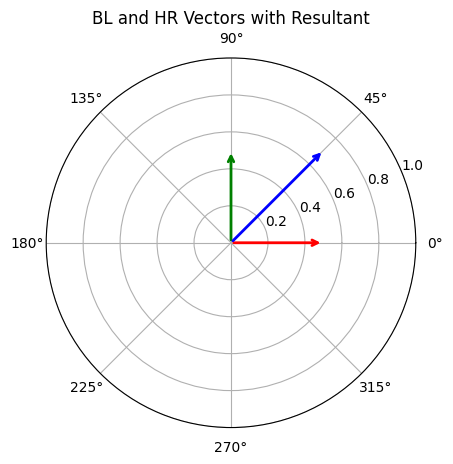

In [189]:
# Example row data (checking that the approach works as expected)
BL_input_weight = 0.5
HR_input_weight = 0.5
BL_angle = 0  # degrees
HR_angle = 90  # degrees

# Convert angles to radians
BL_angle_rad = np.deg2rad(BL_angle)
HR_angle_rad = np.deg2rad(HR_angle)

# Calculate x and y components for BL and HR vectors
BL_x = BL_input_weight * np.cos(BL_angle_rad)
BL_y = BL_input_weight * np.sin(BL_angle_rad)
HR_x = HR_input_weight * np.cos(HR_angle_rad)
HR_y = HR_input_weight * np.sin(HR_angle_rad)

# Compute resultant x and y components
resultant_x = BL_x + HR_x
resultant_y = BL_y + HR_y

# Convert resultant vector to polar form (magnitude and angle)
resultant_magnitude = np.sqrt(resultant_x**2 + resultant_y**2)
resultant_angle_rad = np.arctan2(resultant_y, resultant_x)

# Create a polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# Plot the BL vector (from origin)
ax.annotate("", xy=(BL_angle_rad, BL_input_weight), xytext=(0, 0),
            arrowprops=dict(arrowstyle="->", color='red', lw=2), label='BL vector')

# Plot the HR vector (from origin)
ax.annotate("", xy=(HR_angle_rad, HR_input_weight), xytext=(0, 0),
            arrowprops=dict(arrowstyle="->", color='green', lw=2), label='HR vector')

# Plot the resultant vector (from origin)
ax.annotate("", xy=(resultant_angle_rad, resultant_magnitude), xytext=(0, 0),
            arrowprops=dict(arrowstyle="->", color='blue', lw=2), label='Resultant vector')

# Set plot labels and title
ax.set_title("BL and HR Vectors with Resultant")

plt.show()

### Plotting

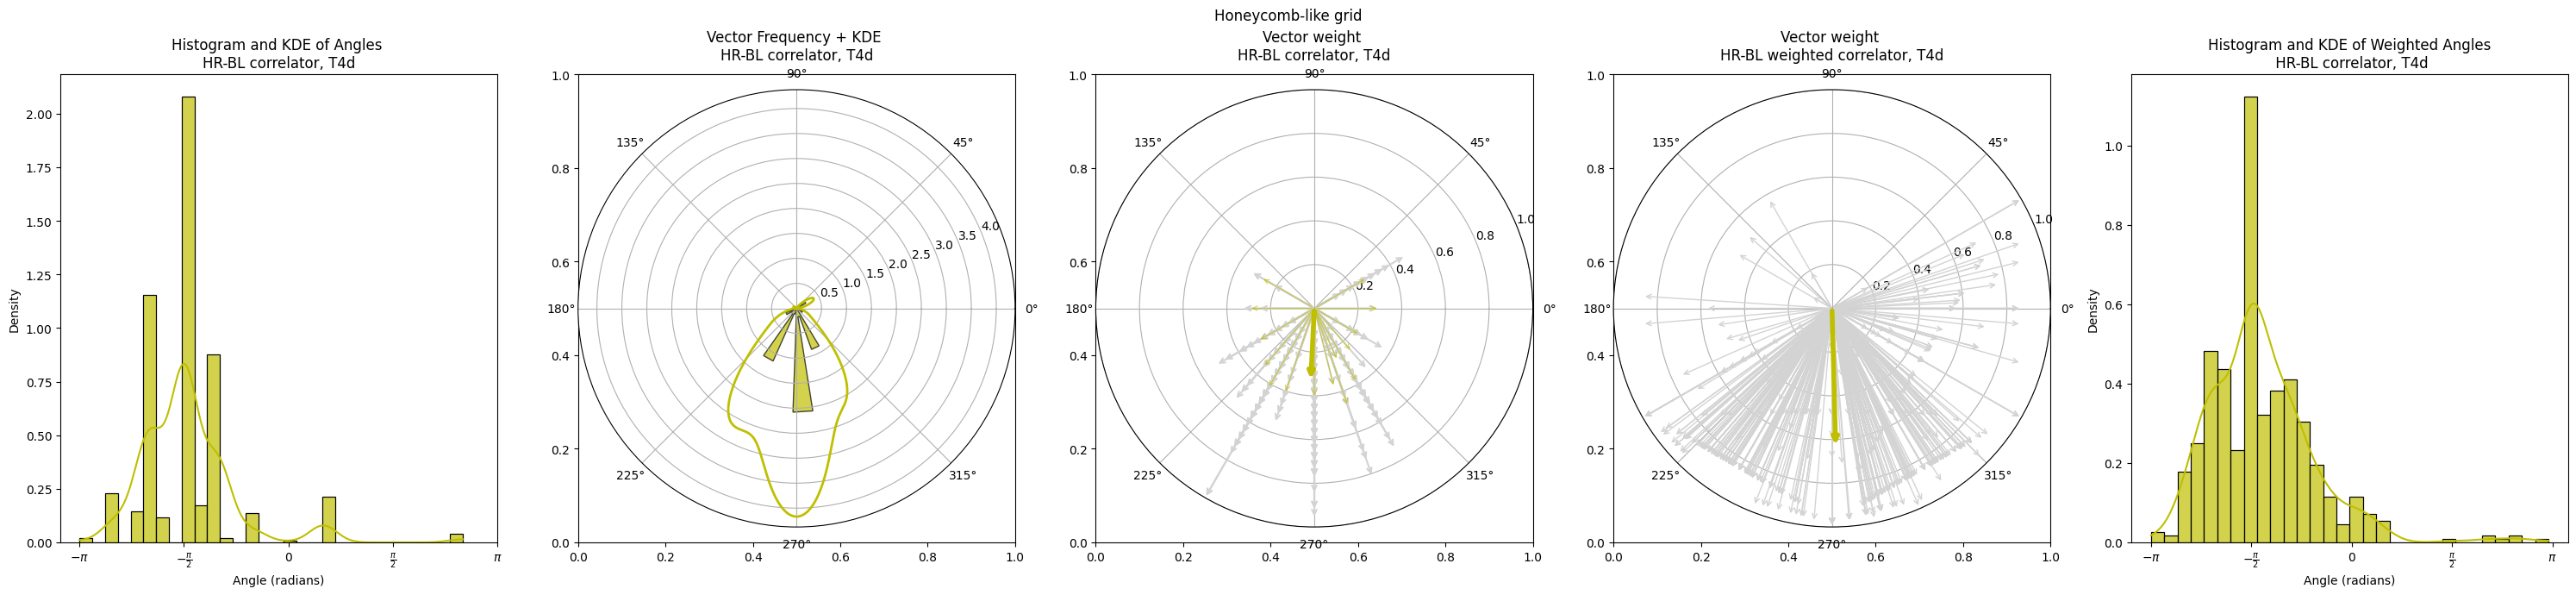

In [190]:
# Extracting angles and defining vector length
angles = HR_BL_unique_highest_inputs_filtered['angle']  # assuming angles are in degrees
angles_rad = np.radians(angles)  # Convert angles to radians
vector_length = f'max_norm_{correlator}_synapses'  # Choose the variable you wanna plot in subplot 4

# Angle normalization
if to_cell_of_interest == 'T4b': # Normalize angles to range 0 to 2π
    angles_rad = np.mod(angles_rad, 2 * np.pi) 
else:
    angles_rad = np.mod(angles_rad + np.pi, 2 * np.pi) - np.pi # Normalize angles to the range -π to π



# Plotting
fig, axs = plt.subplots(1, 5, figsize=(30, 7))  # Adjust the figsize for the extra subplot

# Histogram + KDE Plot for angles_rad
sns.histplot(angles_rad, ax=axs[0], kde=True, color=color_dict[to_cell_of_interest], bins=30, stat="density", edgecolor='black', alpha=0.7)
axs[0].set_title(f'Histogram and KDE of Angles \n{correlator} correlator, {to_cell_of_interest}')
axs[0].set_xlabel('Angle (radians)')
axs[0].set_ylabel('Density')

# Set custom ticks and labels
ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
tick_labels = [r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$']

# For layer B
if to_cell_of_interest == 'T4b':
    ticks = [0, np.pi/2, np.pi, 1.5*np.pi, 2*np.pi]
    tick_labels = [r'$0$', r'$0.5\pi$', r'$\pi$', r'$1.5\pi$', r'$2\pi$']

    
axs[0].set_xticks(ticks)
axs[0].set_xticklabels(tick_labels)

# Polar Plot (HR-BL weighted sum)
axs[1] = plt.subplot(152, projection='polar')
axs[1].set_title(f'Vector Frequency + KDE \n{correlator} correlator, {to_cell_of_interest}')

# Plot the histogram
hist, bin_edges = np.histogram(angles_rad, bins=30, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
axs[1].hist(angles_rad, bins=30, density=True, edgecolor='black', color=color_dict[to_cell_of_interest], alpha=0.7, histtype='stepfilled')

# Calculate the KDE
kde = gaussian_kde(angles_rad, bw_method='scott')  # Adjust the bandwidth method if needed
theta = np.linspace(-np.pi, np.pi, 1000)  # Cover the range from -pi to pi
kde_values = kde(theta) * 5  # This extra number (e.g., +5) has been manually added to adjust the fit

# Plot the KDE on the polar plot
axs[1].plot(theta, kde_values, color=color_dict[to_cell_of_interest], lw=2)

# Polar Plot (Histogram + KDE)
axs[2] = plt.subplot(153, projection='polar')
axs[2].set_title(f'Vector weight \n{correlator} correlator, {to_cell_of_interest}')

# Initialize lists to store the cartesian coordinates
x_components = []
y_components = []
angles_rad = []
radii = []

for _, row in HR_BL_unique_highest_inputs_filtered.iterrows():
    # Convert angle from degrees to radians
    angle_rad = np.deg2rad(row['angle'])
    radius = row[vector_length]

    # Store angles and radii for averaging
    angles_rad.append(angle_rad)
    radii.append(radius)

    # Apply noise to the angle
    noise = np.deg2rad(np.random.normal(loc=0, scale=10))
    perturbed_angle = angle_rad + noise
    perturbed_angle = angle_rad
    
    # Plot the vector using annotate to create an arrow
    axs[2].annotate("", xy=(perturbed_angle, radius), xytext=(0, 0),
                arrowprops=dict(arrowstyle="->", color='lightgray', lw=1.5))
    
    # Store the cartesian coordinates
    x_components.append(radius * np.cos(angle_rad))
    y_components.append(radius * np.sin(angle_rad))

# Calculate the average x and y components
avg_x = np.mean(x_components)
avg_y = np.mean(y_components)

# Convert the average x and y components back to polar coordinates
avg_radius = np.sqrt(avg_x**2 + avg_y**2)
avg_angle = np.arctan2(avg_y, avg_x)

# Plot the average vector as a blue arrow
axs[2].annotate("", xy=(avg_angle, avg_radius), xytext=(0, 0),
            arrowprops=dict(arrowstyle="->", color=color_dict[to_cell_of_interest], lw=4))

# Convert lists to a DataFrame to group by angle
angle_radius_df = pd.DataFrame({
    'angle_rad': angles_rad,
    'radius': radii
})

# Group by angle and calculate the average radius for each angle
average_radii = angle_radius_df.groupby('angle_rad').mean().reset_index()

# Plot the average vectors as red arrows
for _, row in average_radii.iterrows():
    axs[2].annotate("", xy=(row['angle_rad'], row['radius']), xytext=(0, 0),
                arrowprops=dict(arrowstyle="->", color=color_dict[to_cell_of_interest], lw=0.5))

# Plot configuration
axs[2].set_rmin(0)
axs[2].set_rmax(HR_BL_unique_highest_inputs_filtered[vector_length].max())

# Polar Plot (Vectors)
axs[3] = plt.subplot(154, projection='polar')
axs[3].set_title(f'Vector weight \nHR-BL weighted correlator, {to_cell_of_interest}')

# Loop through each row to plot the vectors
for index, row in df.iterrows():
    angle_rad = np.deg2rad(row['HR-BL_weighted_angle'])  # Convert the angle back to radians for polar plot
    radius = row['HR-BL_weighted_weight']
    
    axs[3].annotate("", xy=(angle_rad, radius), xytext=(0, 0),
                arrowprops=dict(arrowstyle="->", color='lightgray', lw=1))

# Plot the average vector as a blue arrow
axs[3].annotate("", xy=(avg_resultant_angle, avg_resultant_radius), xytext=(0, 0),
            arrowprops=dict(arrowstyle="->", color=color_dict[to_cell_of_interest], lw=4))

# PLot frequencies of weighed angles
weighted_angles = HR_BL_unique_highest_inputs_filtered['HR-BL_weighted_angle']  # assuming angles are in degrees
weighted_angles_rad = np.radians(weighted_angles)  # Convert angles to radians


# Angle normalization
if to_cell_of_interest == 'T4b': # Normalize angles to range 0 to 2π
    weighted_angles_rad = np.mod(weighted_angles_rad, 2 * np.pi) 
else:
    weighted_angles_rad = np.mod(weighted_angles_rad + np.pi, 2 * np.pi) - np.pi # Normalize angles to the range -π to π


# Plot frequencies of weighted angles with histogram + KDE
sns.histplot(weighted_angles_rad, ax=axs[4], kde=True, color=color_dict[to_cell_of_interest], bins=30, stat="density", edgecolor='black', alpha=0.7)
axs[4].set_title(f'Histogram and KDE of Weighted Angles\n HR-BL correlator, {to_cell_of_interest}')
axs[4].set_xlabel('Angle (radians)')
axs[4].set_ylabel('Density')

# Set custom ticks and labels
axs[4].set_xticks(ticks)
axs[4].set_xticklabels(tick_labels)

# Show plots
plt.suptitle('Honeycomb-like grid')
plt.tight_layout()
plt.show()


In [191]:
### Filtering data based on BL-HR alignment, giving stronger DSI

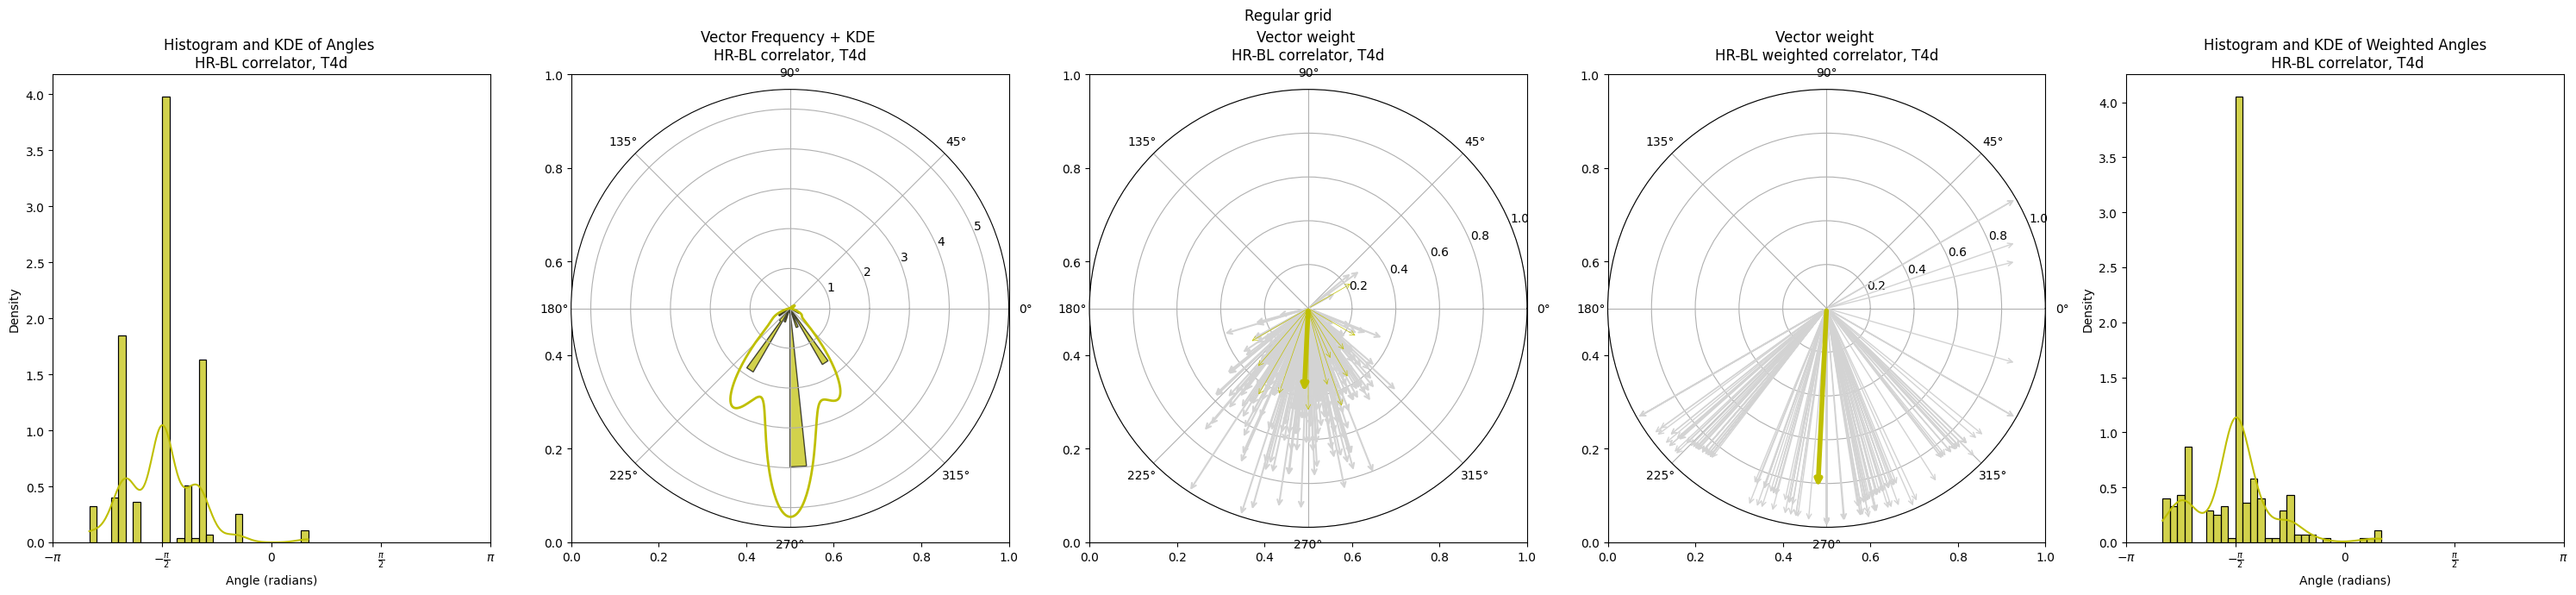

In [197]:
# Fiiltering based on BL-HR vector radius
quantile_threshold = HR_BL_unique_highest_inputs_filtered['HR-BL_weighted_weight'].quantile(0.5)
HR_BL_unique_highest_inputs_weight_filtered = HR_BL_unique_highest_inputs_filtered[HR_BL_unique_highest_inputs_filtered['HR-BL_weighted_weight'] > quantile_threshold ].copy()


# Selecting Data
df = HR_BL_unique_highest_inputs_weight_filtered
HR_weight_variable = 'HR_input_weight_HR-BL' # 'HR_input_weight'
BL_weight_variable = 'BL_input_weight_HR-BL' # 'BL_input_weight'

# Convert angles from degrees to radians
df['BL_angle_rad'] = np.deg2rad(df['BL_angle'])
df['HR_angle_rad'] = np.deg2rad(df['HR_angle'])

# Calculate x and y components of BL and HR vectors
df['BL_x'] = df[BL_weight_variable] * np.cos(df['BL_angle_rad'])
df['BL_y'] = df[BL_weight_variable] * np.sin(df['BL_angle_rad'])
df['HR_x'] = df[HR_weight_variable] * np.cos(df['HR_angle_rad'])
df['HR_y'] = df[HR_weight_variable] * np.sin(df['HR_angle_rad'])

# Compute resultant x and y components by summing the BL and HR components
df['resultant_x'] = df['BL_x'] + df['HR_x']
df['resultant_y'] = df['BL_y'] + df['HR_y']

# Calculate the average x and y components
avg_resultant_x = df['resultant_x'].mean()
avg_resultant_y = df['resultant_y'].mean()

# Convert the average x and y components back to polar coordinates
avg_resultant_radius = np.sqrt(avg_resultant_x**2 + avg_resultant_y**2)
avg_resultant_angle = np.arctan2(avg_resultant_y, avg_resultant_x)

# Convert resultant vector to polar form (magnitude and angle)
df['HR-BL_weighted_weight'] = np.sqrt(df['resultant_x']**2 + df['resultant_y']**2)
df['HR-BL_weighted_angle'] = np.rad2deg(np.arctan2(df['resultant_y'], df['resultant_x']))


# Extracting angles and defining vector length
angles = HR_BL_unique_highest_inputs_weight_filtered['angle']  # assuming angles are in degrees
angles_rad = np.radians(angles)  # Convert angles to radians
vector_length = f'max_norm_{correlator}_synapses'  # Choose the variable you wanna plot in subplot 4

# Angle normalization
if to_cell_of_interest == 'T4b': # Normalize angles to range 0 to 2π
    angles_rad = np.mod(angles_rad, 2 * np.pi) 
else:
    angles_rad = np.mod(angles_rad + np.pi, 2 * np.pi) - np.pi # Normalize angles to the range -π to π



# Plotting
fig, axs = plt.subplots(1, 5, figsize=(30, 7))  # Adjust the figsize for the extra subplot

# Histogram + KDE Plot for angles_rad
sns.histplot(angles_rad, ax=axs[0], kde=True, color=color_dict[to_cell_of_interest], bins=30, stat="density", edgecolor='black', alpha=0.7)
axs[0].set_title(f'Histogram and KDE of Angles \n{correlator} correlator, {to_cell_of_interest}')
axs[0].set_xlabel('Angle (radians)')
axs[0].set_ylabel('Density')

# Set custom ticks and labels
ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
tick_labels = [r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$']

# For layer B
if to_cell_of_interest == 'T4b':
    ticks = [0, np.pi/2, np.pi, 1.5*np.pi, 2*np.pi]
    tick_labels = [r'$0$', r'$0.5\pi$', r'$\pi$', r'$1.5\pi$', r'$2\pi$']

    
axs[0].set_xticks(ticks)
axs[0].set_xticklabels(tick_labels)

# Polar Plot (HR-BL weighted sum)
axs[1] = plt.subplot(152, projection='polar')
axs[1].set_title(f'Vector Frequency + KDE \n{correlator} correlator, {to_cell_of_interest}')

# Plot the histogram
hist, bin_edges = np.histogram(angles_rad, bins=30, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
axs[1].hist(angles_rad, bins=30, density=True, edgecolor='black', color=color_dict[to_cell_of_interest], alpha=0.7, histtype='stepfilled')

# Calculate the KDE
kde = gaussian_kde(angles_rad, bw_method='scott')  # Adjust the bandwidth method if needed
theta = np.linspace(-np.pi, np.pi, 1000)  # Cover the range from -pi to pi
kde_values = kde(theta) * 5  # This extra number (e.g., +5) has been manually added to adjust the fit

# Plot the KDE on the polar plot
axs[1].plot(theta, kde_values, color=color_dict[to_cell_of_interest], lw=2)

# Polar Plot (Histogram + KDE)
axs[2] = plt.subplot(153, projection='polar')
axs[2].set_title(f'Vector weight \n{correlator} correlator, {to_cell_of_interest}')

# Initialize lists to store the cartesian coordinates
x_components = []
y_components = []
angles_rad = []
radii = []

for _, row in HR_BL_unique_highest_inputs_weight_filtered.iterrows():
    # Convert angle from degrees to radians
    angle_rad = np.deg2rad(row['angle'])
    radius = row[vector_length]

    # Store angles and radii for averaging
    angles_rad.append(angle_rad)
    radii.append(radius)

    # Apply noise to the angle
    noise = np.deg2rad(np.random.normal(loc=0, scale=10))
    perturbed_angle = angle_rad + noise
    #perturbed_angle = angle_rad
    
    # Plot the vector using annotate to create an arrow
    axs[2].annotate("", xy=(perturbed_angle, radius), xytext=(0, 0),
                arrowprops=dict(arrowstyle="->", color='lightgray', lw=1.5))
    
    # Store the cartesian coordinates
    x_components.append(radius * np.cos(angle_rad))
    y_components.append(radius * np.sin(angle_rad))

# Calculate the average x and y components
avg_x = np.mean(x_components)
avg_y = np.mean(y_components)

# Convert the average x and y components back to polar coordinates
avg_radius = np.sqrt(avg_x**2 + avg_y**2)
avg_angle = np.arctan2(avg_y, avg_x)

# Plot the average vector as a blue arrow
axs[2].annotate("", xy=(avg_angle, avg_radius), xytext=(0, 0),
            arrowprops=dict(arrowstyle="->", color=color_dict[to_cell_of_interest], lw=4))

# Convert lists to a DataFrame to group by angle
angle_radius_df = pd.DataFrame({
    'angle_rad': angles_rad,
    'radius': radii
})

# Group by angle and calculate the average radius for each angle
average_radii = angle_radius_df.groupby('angle_rad').mean().reset_index()

# Plot the average vectors as red arrows
for _, row in average_radii.iterrows():
    axs[2].annotate("", xy=(row['angle_rad'], row['radius']), xytext=(0, 0),
                arrowprops=dict(arrowstyle="->", color=color_dict[to_cell_of_interest], lw=0.5))

# Plot configuration
axs[2].set_rmin(0)
axs[2].set_rmax(HR_BL_unique_highest_inputs_weight_filtered[vector_length].max())

# Polar Plot (Vectors)
axs[3] = plt.subplot(154, projection='polar')
axs[3].set_title(f'Vector weight \nHR-BL weighted correlator, {to_cell_of_interest}')

# Loop through each row to plot the vectors
for index, row in df.iterrows():
    angle_rad = np.deg2rad(row['HR-BL_weighted_angle'])  # Convert the angle back to radians for polar plot
    radius = row['HR-BL_weighted_weight']
    
    axs[3].annotate("", xy=(angle_rad, radius), xytext=(0, 0),
                arrowprops=dict(arrowstyle="->", color='lightgray', lw=1))

# Plot the average vector
axs[3].annotate("", xy=(avg_resultant_angle, avg_resultant_radius), xytext=(0, 0),
            arrowprops=dict(arrowstyle="->", color=color_dict[to_cell_of_interest], lw=4))

# PLot frequencies of weighed angles
weighted_angles = HR_BL_unique_highest_inputs_weight_filtered['HR-BL_weighted_angle']  # assuming angles are in degrees
weighted_angles_rad = np.radians(weighted_angles)  # Convert angles to radians


# Angle normalization
if to_cell_of_interest == 'T4b': # Normalize angles to range 0 to 2π
    weighted_angles_rad = np.mod(weighted_angles_rad, 2 * np.pi) 
else:
    weighted_angles_rad = np.mod(weighted_angles_rad + np.pi, 2 * np.pi) - np.pi # Normalize angles to the range -π to π


# Plot frequencies of weighted angles with histogram + KDE
sns.histplot(weighted_angles_rad, ax=axs[4], kde=True, color=color_dict[to_cell_of_interest], bins=30, stat="density", edgecolor='black', alpha=0.7)
axs[4].set_title(f'Histogram and KDE of Weighted Angles\n HR-BL correlator, {to_cell_of_interest}')
axs[4].set_xlabel('Angle (radians)')
axs[4].set_ylabel('Density')

# Set custom ticks and labels
axs[4].set_xticks(ticks)
axs[4].set_xticklabels(tick_labels)

# Show plots
plt.suptitle('Regular grid')
plt.tight_layout()
plt.show()

In [193]:
HR_BL_unique_highest_inputs_filtered['HR-BL_weighted_weight'].quantile(0.5)

0.8717797887081349

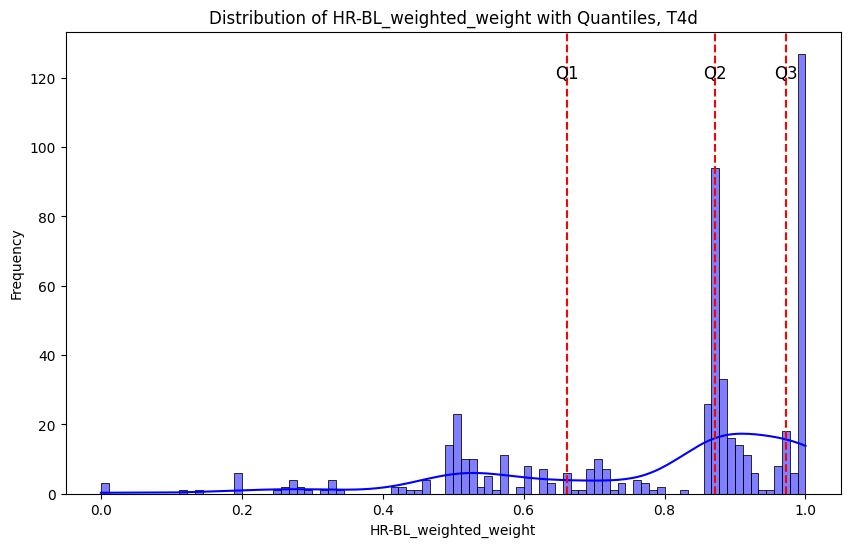

In [194]:
# Looking at the distribution and quantiles of the proxy of a DSI
data = HR_BL_unique_highest_inputs_filtered['HR-BL_weighted_weight']

# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.histplot(data, kde=True, bins=90, color='blue')

# Calculate the quantiles
quantiles = np.quantile(data, [0.25,0.5,0.75])

# Mark the quantiles on the plot
for i, q in enumerate(quantiles, 1):
    plt.axvline(q, color='red', linestyle='--')
    plt.text(q, plt.gca().get_ylim()[1]*0.9, f'Q{i}', color='black', ha='center', fontsize=12)

# Add titles and labels
plt.title(f'Distribution of HR-BL_weighted_weight with Quantiles, {to_cell_of_interest}')
plt.xlabel('HR-BL_weighted_weight')
plt.ylabel('Frequency')

# Show the plot
plt.show()


### Calculate the angle difference between average and most frequent angles.

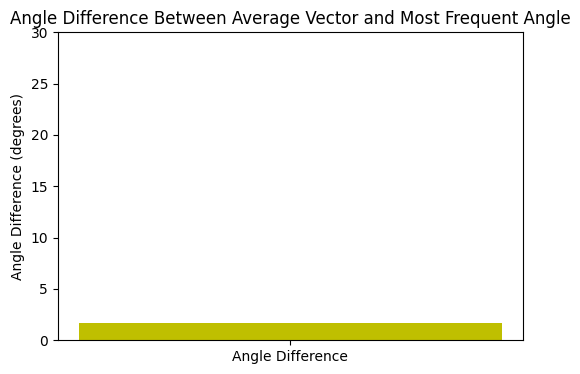

In [195]:
# Step 1: Identify the most frequent angle in angle_radius_df
most_frequent_angle_rad = angle_radius_df['angle_rad'].mode()[0]

# Step 2: Calculate the angle difference between avg_angle and most_frequent_angle_rad
angle_difference_rad = np.arctan2(np.sin(avg_angle - most_frequent_angle_rad),
                                  np.cos(avg_angle - most_frequent_angle_rad))

# Step 3: Convert the angle difference from radians to degrees
angle_difference_deg = np.rad2deg(angle_difference_rad)

# Step 4: take the absolute value
angle_difference_deg = abs(angle_difference_deg)

# Step 4: Plot the angle difference as a bar plot
plt.figure(figsize=(6, 4))
plt.bar(['Angle Difference'], [angle_difference_deg], color=color_dict[to_cell_of_interest])
plt.ylabel('Angle Difference (degrees)')
plt.title('Angle Difference Between Average Vector and Most Frequent Angle')
plt.ylim(0, 30)  # Angle difference can vary between 0 and 180 degrees
plt.show()

In [196]:
angle_difference_deg

1.7019587288199212

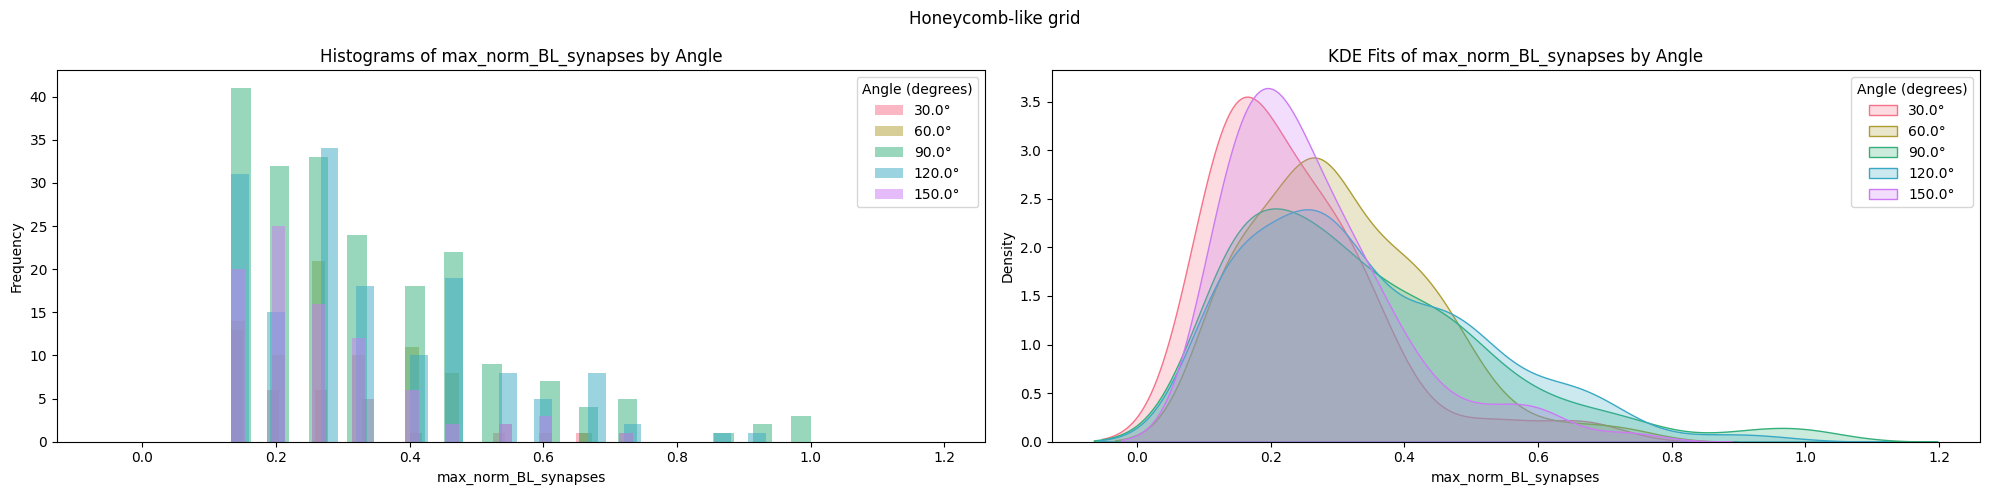

In [163]:
# Convert angle from degrees to radians and add a new column for radians
HR_BL_unique_highest_inputs_filtered['angle_rad'] = np.deg2rad(HR_BL_unique_highest_inputs_filtered['angle'])

# Group by angle and filter groups with more than five_percent_occupancy values (at least in 5% of all columns available)
five_percent_occupancy = round(len(HR_BL_unique_highest_inputs_filtered['angle_rad']) * 5 / 100)
angle_counts = HR_BL_unique_highest_inputs_filtered.groupby('angle_rad').size()
valid_angles = angle_counts[angle_counts > five_percent_occupancy].index

# Prepare the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharex=True)

# Define a color palette
colors = sns.color_palette("husl", len(valid_angles))

# Plot histograms on the first subplot
for angle_rad, color in zip(valid_angles, colors):
    filtered_data = HR_BL_unique_highest_inputs_filtered[HR_BL_unique_highest_inputs_filtered['angle_rad'] == angle_rad]
    axes[0].hist(filtered_data['max_norm_BL_synapses'], bins=30, color=color, alpha=0.5, label=f'{np.rad2deg(angle_rad):.1f}°')

axes[0].set_title('Histograms of max_norm_BL_synapses by Angle')
axes[0].set_ylabel('Frequency')
axes[0].set_xlabel('max_norm_BL_synapses')
axes[0].legend(title='Angle (degrees)')
axes[0].grid(False)

# Plot KDE fits on the second subplot
for angle_rad, color in zip(valid_angles, colors):
    filtered_data = HR_BL_unique_highest_inputs_filtered[HR_BL_unique_highest_inputs_filtered['angle_rad'] == angle_rad]
    sns.kdeplot(filtered_data['max_norm_BL_synapses'], ax=axes[1], color=color, label=f'{np.rad2deg(angle_rad):.1f}°', fill=True)

axes[1].set_title('KDE Fits of max_norm_BL_synapses by Angle')
axes[1].set_xlabel('max_norm_BL_synapses')
axes[1].set_ylabel('Density')
axes[1].legend(title='Angle (degrees)')
axes[1].grid(False)

# Adjust layout for better spacing
plt.suptitle('Honeycomb-like grid')
plt.tight_layout()
plt.show()

## 4.2. Regular grid

TypeError: 'numpy.float64' object is not iterable

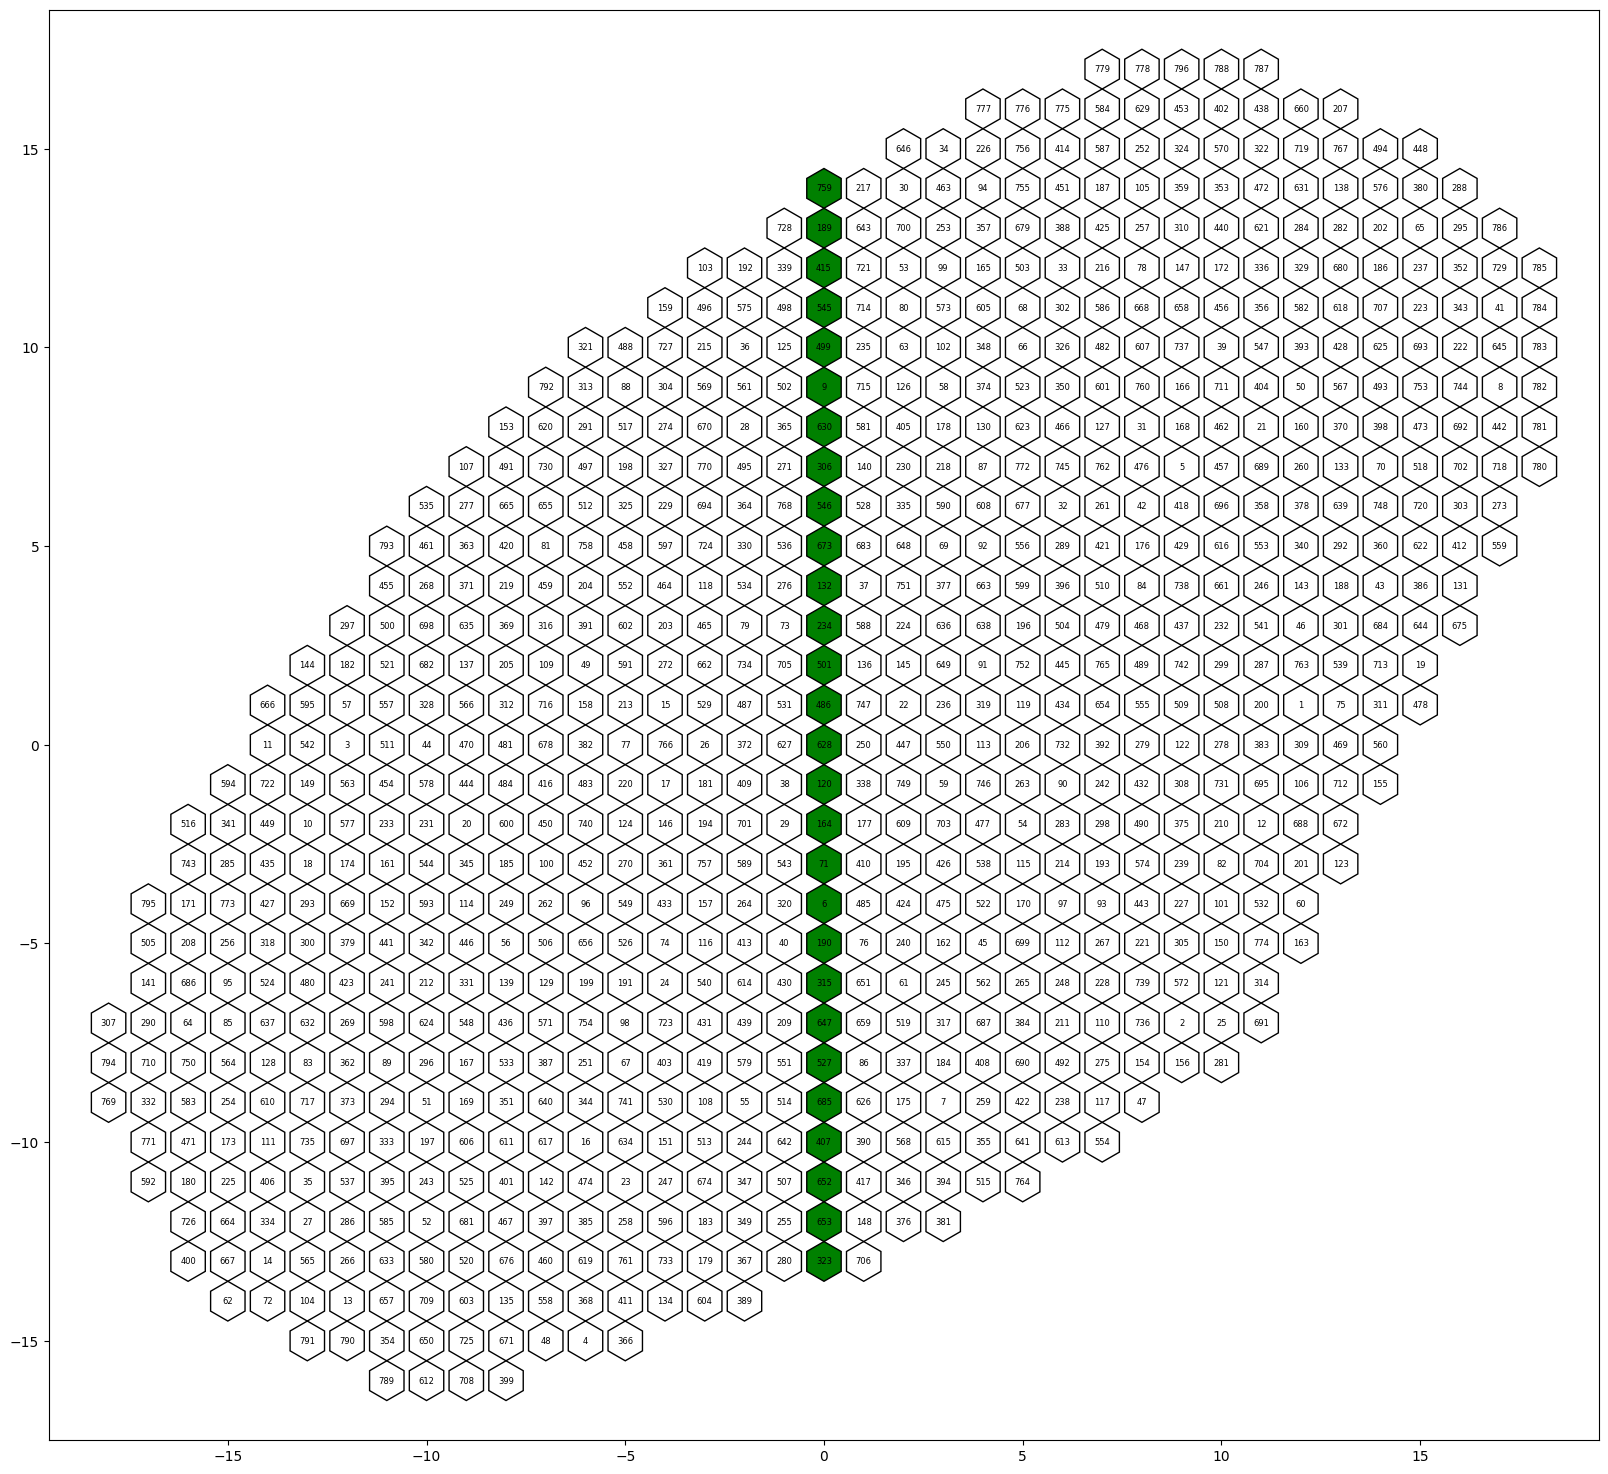

In [164]:
## Plotting on the 2D lattice: check access to each point and axis
fig, ax, hexagons = plot_hex_grid(original_p, original_q, hex_size=0.5, spacing=1.0, fig_size=(20, 20), labels=labels, label_type='manual_labels', text_size=6)

# Example to color hexagons based on a condition
for p_x, p_y in p:
    color_in_p = p_x
    color_in_q = p_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(original_p, original_q)):
        if x_pos == color_in_p and y_pos == color_in_q:
            hexagon.set_facecolor('g')

for q_x, q_y in q:
    color_in_p = q_x
    color_in_q = q_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(original_p, original_q)):
        if x_pos == color_in_p and y_pos == color_in_q:
            hexagon.set_facecolor('c')
            

for h_x, h_y in h:
    color_in_p = h_x
    color_in_q = h_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(original_p, original_q)):
        if x_pos == color_in_p and y_pos == color_in_q:
            hexagon.set_facecolor('y')


for v_x, v_y in v:
    color_in_p = v_x
    color_in_q = v_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(original_p, original_q)):
        if x_pos == color_in_p and y_pos == color_in_q:
            hexagon.set_facecolor('grey')


new_180_0_deg_axis = list(zip(new_h_x_ls,h_y_ls)) # This is my reference line to calculate vectors angles. (currently used. It is the eye´s equator)
new_270_90_deg_axis = list(zip(new_v_x_ls,v_y_ls)) # This is my reference line to calculate vectors angles. (currently NOT used. It is the perpendicular line to the eye´s equator)

# Draw vector from hexagon to hexagon
# Savecolumn_ids (start and end) based on the expected preferred direction (PD) for all correlators of a list


corr_ls = ['BL', 'HR', 'HR-BL']
for corr_i in corr_ls:

    if corr_i == 'BL':
        start_ids = [int(x) for x in HR_BL_unique_highest_inputs_filtered.home_column_id.tolist()]
        end_ids = [int(x) for x in HR_BL_unique_highest_inputs_filtered.BL_column_id.tolist()] 
    elif corr_i == 'HR':
        start_ids = [int(x) for x in HR_BL_unique_highest_inputs_filtered.HR_column_id.tolist()]
        end_ids = [int(x) for x in HR_BL_unique_highest_inputs_filtered.home_column_id.tolist()]  
    elif corr_i == 'HR-BL':
        start_ids = [int(x) for x in HR_BL_unique_highest_inputs_filtered.HR_column_id.tolist()]
        end_ids = [int(x) for x in HR_BL_unique_highest_inputs_filtered.BL_column_id.tolist()]  

    #Getting vector coordinates    
    start_coords_ls = []
    end_coords_ls = []
    for start_id, end_id in zip(start_ids, end_ids):
        start_id_p = df_grid[df_grid.column_id == str(start_id)].p.values[0]
        start_id_q = df_grid[df_grid.column_id == str(start_id)].q.values[0]
        start_coords_ls.append((start_id_p,start_id_q))
    
        
        end_id_p = df_grid[df_grid.column_id == str(end_id)].p.values[0]
        end_id_q = df_grid[df_grid.column_id == str(end_id)].q.values[0]
        end_coords_ls.append((end_id_p,end_id_q))
    
    #Saving coordinates in the main data frame
    str_start_coords = f'{corr_i}_start_coords'
    str_end_coords = f'{corr_i}_end_coords'
    HR_BL_unique_highest_inputs_filtered[str_start_coords] = start_coords_ls
    HR_BL_unique_highest_inputs_filtered[str_end_coords] = end_coords_ls

#Saving start and end IDs for BL, HR and HR-BL
HR_BL_unique_highest_inputs_filtered['BL_start_ids'] = [int(x) for x in HR_BL_unique_highest_inputs_filtered.home_column_id.tolist()]
HR_BL_unique_highest_inputs_filtered['BL_end_ids'] = [int(x) for x in HR_BL_unique_highest_inputs_filtered.BL_column_id.tolist()] 

HR_BL_unique_highest_inputs_filtered['HR_start_ids'] = [int(x) for x in HR_BL_unique_highest_inputs_filtered.HR_column_id.tolist()]
HR_BL_unique_highest_inputs_filtered['HR_end_ids'] = [int(x) for x in HR_BL_unique_highest_inputs_filtered.home_column_id.tolist()]  

HR_BL_unique_highest_inputs_filtered['HR-BL_start_ids'] = [int(x) for x in HR_BL_unique_highest_inputs_filtered.HR_column_id.tolist()]
HR_BL_unique_highest_inputs_filtered['HR-BL_end_ids'] = [int(x) for x in HR_BL_unique_highest_inputs_filtered.BL_column_id.tolist()]  



#Drawing vectors of a specific correlator
if corr_i == 'BL':
    start_coords_ls = HR_BL_unique_highest_inputs_filtered['BL_start_coords']
    end_coords_ls = HR_BL_unique_highest_inputs_filtered['BL_end_coords']
elif corr_i == 'HR':
    start_coords_ls = HR_BL_unique_highest_inputs_filtered['HR_start_coords']
    end_coords_ls = HR_BL_unique_highest_inputs_filtered['HR_end_coords']
elif corr_i == 'HR-BL':
    start_coords_ls = HR_BL_unique_highest_inputs_filtered['HR-BL_start_coords']
    end_coords_ls = HR_BL_unique_highest_inputs_filtered['HR-BL_end_coords']
    
for start_coord, end_coord in zip(start_coords_ls,end_coords_ls):
    # Find the coordinates of the start and end hexagons
    x_start = start_coord[0]
    y_start = start_coord[1]
    
    x_end = end_coord[0]
    y_end = end_coord[1]

    draw_vector(ax, x_start, y_start, x_end, y_end, color=color_dict[to_cell_of_interest])

plt.title(f'{correlator} correlator, {to_cell_of_interest}')
plt.show()

In [ ]:
# Define the angle of the diagonal line y = -x
# The angle of y = -x is -45 degrees (or -π/4 radians)
diagonal_angle_rad = np.radians(-45)

corr_ls = ['BL', 'HR', 'HR-BL']
for corr_i in corr_ls:
    # Prepare the list for angles and other variable
    angles = []
    start_ids = HR_BL_unique_highest_inputs_filtered[f'{corr_i}_start_ids'].tolist()
    end_ids = HR_BL_unique_highest_inputs_filtered[f'{corr_i}_end_ids'].tolist()
    start_coords_ls = HR_BL_unique_highest_inputs_filtered[f'{corr_i}_start_coords'].tolist()
    end_coords_ls = HR_BL_unique_highest_inputs_filtered[f'{corr_i}_end_coords'].tolist()
    
    # Calculate the angle for each vector
    for start_id, end_id, start_coord, end_coord in zip(start_ids, end_ids, start_coords_ls, end_coords_ls):
        # Coordinates
        x_start, y_start = start_coord
        x_end, y_end = end_coord
        
        # Calculate the change in coordinates
        dx = x_end - x_start
        dy = y_end - y_start
        
        # Calculate the angle in radians relative to the x-axis
        angle_rad = np.arctan2(dy, dx)
        
        # Adjust the angle relative to the new reference line
        adjusted_angle_rad = angle_rad - diagonal_angle_rad
        
        # Convert to degrees
        adjusted_angle_deg = np.degrees(adjusted_angle_rad)
        
        # Normalize the angle to be in the range [0, 360) degrees
        adjusted_angle_deg = (adjusted_angle_deg + 360) % 360
        adjusted_angle_deg = round(adjusted_angle_deg) # rounding angle's values
        
        # Append the result to the angles list
        angles.append((start_id, end_id, adjusted_angle_deg))
    
    # Create a DataFrame with the results
    angles_df = pd.DataFrame(angles, columns=['start_id', 'end_id', 'angle']) 
    
    # Updating main data frame with angles
    HR_BL_unique_highest_inputs_filtered[f'{corr_i}_angle'] = angles_df['angle'].to_list()

# Display the DataFrame
display(HR_BL_unique_highest_inputs_filtered.head())

In [ ]:
# Define the angle of the diagonal line y = -x
# The angle of y = -x is -45 degrees (or -π/4 radians)
diagonal_angle_rad = np.radians(-45)

# Prepare the list for angles
angles = []

# Calculate the angle for each vector
start_ids = HR_BL_unique_highest_inputs_filtered[f'{correlator}_start_ids'].tolist()
end_ids = HR_BL_unique_highest_inputs_filtered[f'{correlator}_end_ids'].tolist()
start_coords_ls = HR_BL_unique_highest_inputs_filtered[f'{correlator}_start_coords'].tolist()
end_coords_ls = HR_BL_unique_highest_inputs_filtered[f'{correlator}_end_coords'].tolist()

# Calculate the angle for each vector
for start_id, end_id, start_coord, end_coord in zip(start_ids, end_ids, start_coords_ls, end_coords_ls):
    # Coordinates
    x_start, y_start = start_coord
    x_end, y_end = end_coord
    
    # Calculate the change in coordinates
    dx = x_end - x_start
    dy = y_end - y_start
    
    # Calculate the angle in radians relative to the x-axis
    angle_rad = np.arctan2(dy, dx)
    
    # Adjust the angle relative to the diagonal line y = -x
    adjusted_angle_rad = angle_rad - diagonal_angle_rad
    
    # Convert to degrees
    adjusted_angle_deg = np.degrees(adjusted_angle_rad)
    
    # Normalize the angle to be in the range [0, 360) degrees
    adjusted_angle_deg = (adjusted_angle_deg + 360) % 360
    
    # Append the result to the angles list
    angles.append((start_id, end_id, adjusted_angle_deg))

# Create a DataFrame with the results
angles_df = pd.DataFrame(angles, columns=['start_id', 'end_id', 'angle'])

# Updating main data frame with angles
HR_BL_unique_highest_inputs_filtered['angle'] = angles_df['angle'].to_list()


# Display the DataFrame
display(HR_BL_unique_highest_inputs_filtered.head())

### Adding synaptic weight to PD vectors

The main idea here is to add to each vector an absolute synapse value or a normalized (relative) weight as the length of the vectors. Then, analyze and plot the vector average. 

In [ ]:
## Getting all synaptic data 
total_synapse_num = ol_connections.groupby('to_cell_id')['synapses'].agg('sum')


## Getting input weights

# Map the total synapse numbers to the corresponding 'home_cell_id' in the filtered DataFrame
HR_BL_unique_highest_inputs_filtered['total_input_synapses'] = HR_BL_unique_highest_inputs_filtered['home_cell_id'].map(total_synapse_num)

# Calculate the actual input weights
HR_BL_unique_highest_inputs_filtered['BL_input_weight'] = HR_BL_unique_highest_inputs_filtered['BL_synapses'] / HR_BL_unique_highest_inputs_filtered['total_input_synapses']
HR_BL_unique_highest_inputs_filtered['HR_input_weight'] = HR_BL_unique_highest_inputs_filtered['HR_synapses'] / HR_BL_unique_highest_inputs_filtered['total_input_synapses']


#Normalizing absolute synapse number
_max_norm_BL_synapses_ls = HR_BL_unique_highest_inputs_filtered['BL_synapses'] / HR_BL_unique_highest_inputs_filtered['BL_synapses'].max()
HR_BL_unique_highest_inputs_filtered['max_norm_BL_synapses'] = _max_norm_BL_synapses_ls

_max_norm_HR_synapses_ls = HR_BL_unique_highest_inputs_filtered['HR_synapses'] / HR_BL_unique_highest_inputs_filtered['HR_synapses'].max()
HR_BL_unique_highest_inputs_filtered['max_norm_HR_synapses'] = _max_norm_HR_synapses_ls

HR_BL_unique_highest_inputs_filtered['HR-BL_synapses'] = HR_BL_unique_highest_inputs_filtered['BL_synapses'] + HR_BL_unique_highest_inputs_filtered['HR_synapses']
_max_norm_HR_BL_synapses_ls = HR_BL_unique_highest_inputs_filtered['HR-BL_synapses'] / HR_BL_unique_highest_inputs_filtered['HR-BL_synapses'].max()
HR_BL_unique_highest_inputs_filtered['max_norm_HR-BL_synapses'] = _max_norm_HR_BL_synapses_ls



#Normalizing input weights
_max_norm_BL_input_weight_ls = HR_BL_unique_highest_inputs_filtered['BL_input_weight'] / HR_BL_unique_highest_inputs_filtered['BL_input_weight'].max()
HR_BL_unique_highest_inputs_filtered['max_norm_BL_input_weight'] = _max_norm_BL_input_weight_ls

_max_norm_HR_input_weight_ls = HR_BL_unique_highest_inputs_filtered['HR_input_weight'] / HR_BL_unique_highest_inputs_filtered['HR_input_weight'].max()
HR_BL_unique_highest_inputs_filtered['max_norm_HR_input_weight'] = _max_norm_HR_input_weight_ls

# Calculate input weights considering only HR ( Mi9) and BL (Mi4) inputs for the total number of synapses
HR_BL_sum = HR_BL_unique_highest_inputs_filtered['BL_synapses'] + HR_BL_unique_highest_inputs_filtered['HR_synapses']
HR_BL_unique_highest_inputs_filtered['BL_input_weight_HR-BL'] = HR_BL_unique_highest_inputs_filtered['BL_synapses'] / HR_BL_sum 
HR_BL_unique_highest_inputs_filtered['HR_input_weight_HR-BL'] = HR_BL_unique_highest_inputs_filtered['HR_synapses'] / HR_BL_sum 




### Calculating a weighted HR-BL correlator

In [ ]:
# Selecting Data
df = HR_BL_unique_highest_inputs_filtered
HR_weight_variable = 'HR_input_weight_HR-BL' # 'HR_input_weight'
BL_weight_variable = 'BL_input_weight_HR-BL' # 'BL_input_weight'

# Convert angles from degrees to radians
df['BL_angle_rad'] = np.deg2rad(df['BL_angle'])
df['HR_angle_rad'] = np.deg2rad(df['HR_angle'])

# Calculate x and y components of BL and HR vectors
df['BL_x'] = df[BL_weight_variable] * np.cos(df['BL_angle_rad'])
df['BL_y'] = df[BL_weight_variable] * np.sin(df['BL_angle_rad'])
df['HR_x'] = df[HR_weight_variable] * np.cos(df['HR_angle_rad'])
df['HR_y'] = df[HR_weight_variable] * np.sin(df['HR_angle_rad'])

# Compute resultant x and y components by summing the BL and HR components
df['resultant_x'] = df['BL_x'] + df['HR_x']
df['resultant_y'] = df['BL_y'] + df['HR_y']

# Calculate the average x and y components
avg_resultant_x = df['resultant_x'].mean()
avg_resultant_y = df['resultant_y'].mean()

# Convert the average x and y components back to polar coordinates
avg_resultant_radius = np.sqrt(avg_resultant_x**2 + avg_resultant_y**2)
avg_resultant_angle = np.arctan2(avg_resultant_y, avg_resultant_x)

# Convert resultant vector to polar form (magnitude and angle)
df['HR-BL_weighted_weight'] = np.sqrt(df['resultant_x']**2 + df['resultant_y']**2)
df['HR-BL_weighted_angle'] = np.rad2deg(np.arctan2(df['resultant_y'], df['resultant_x']))

### Plotting

In [ ]:
# Extracting angles and defining vector length
angles = HR_BL_unique_highest_inputs_filtered['angle']  # assuming angles are in degrees
angles_rad = np.radians(angles)  # Convert angles to radians
vector_length = f'max_norm_{correlator}_synapses'  # Choose the variable you wanna plot in subplot 4

# Angle normalization
if to_cell_of_interest == 'T4b': # Normalize angles to range 0 to 2π
    angles_rad = np.mod(angles_rad, 2 * np.pi) 
else:
    angles_rad = np.mod(angles_rad + np.pi, 2 * np.pi) - np.pi # Normalize angles to the range -π to π



# Plotting
fig, axs = plt.subplots(1, 5, figsize=(30, 7))  # Adjust the figsize for the extra subplot

# Histogram + KDE Plot for angles_rad
sns.histplot(angles_rad, ax=axs[0], kde=True, color=color_dict[to_cell_of_interest], bins=30, stat="density", edgecolor='black', alpha=0.7)
axs[0].set_title(f'Histogram and KDE of Angles \n{correlator} correlator, {to_cell_of_interest}')
axs[0].set_xlabel('Angle (radians)')
axs[0].set_ylabel('Density')

# Set custom ticks and labels
ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
tick_labels = [r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$']

# For layer B
if to_cell_of_interest == 'T4b':
    ticks = [0, np.pi/2, np.pi, 1.5*np.pi, 2*np.pi]
    tick_labels = [r'$0$', r'$0.5\pi$', r'$\pi$', r'$1.5\pi$', r'$2\pi$']

    
axs[0].set_xticks(ticks)
axs[0].set_xticklabels(tick_labels)

# Polar Plot (HR-BL weighted sum)
axs[1] = plt.subplot(152, projection='polar')
axs[1].set_title(f'Vector Frequency + KDE \n{correlator} correlator, {to_cell_of_interest}')

# Plot the histogram
hist, bin_edges = np.histogram(angles_rad, bins=30, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
axs[1].hist(angles_rad, bins=30, density=True, edgecolor='black', color=color_dict[to_cell_of_interest], alpha=0.7, histtype='stepfilled')

# Calculate the KDE
kde = gaussian_kde(angles_rad, bw_method='scott')  # Adjust the bandwidth method if needed
theta = np.linspace(-np.pi, np.pi, 1000)  # Cover the range from -pi to pi
kde_values = kde(theta) * 5  # This extra number (e.g., +5) has been manually added to adjust the fit

# Plot the KDE on the polar plot
axs[1].plot(theta, kde_values, color=color_dict[to_cell_of_interest], lw=2)

# Polar Plot (Histogram + KDE)
axs[2] = plt.subplot(153, projection='polar')
axs[2].set_title(f'Vector weight \n{correlator} correlator, {to_cell_of_interest}')

# Initialize lists to store the cartesian coordinates
x_components = []
y_components = []
angles_rad = []
radii = []

for _, row in HR_BL_unique_highest_inputs_filtered.iterrows():
    # Convert angle from degrees to radians
    angle_rad = np.deg2rad(row['angle'])
    radius = row[vector_length]

    # Store angles and radii for averaging
    angles_rad.append(angle_rad)
    radii.append(radius)

    # Apply noise to the angle
    noise = np.deg2rad(np.random.normal(loc=0, scale=10))
    perturbed_angle = angle_rad + noise
    perturbed_angle = angle_rad
    
    # Plot the vector using annotate to create an arrow
    axs[2].annotate("", xy=(perturbed_angle, radius), xytext=(0, 0),
                arrowprops=dict(arrowstyle="->", color='lightgray', lw=1.5))
    
    # Store the cartesian coordinates
    x_components.append(radius * np.cos(angle_rad))
    y_components.append(radius * np.sin(angle_rad))

# Calculate the average x and y components
avg_x = np.mean(x_components)
avg_y = np.mean(y_components)

# Convert the average x and y components back to polar coordinates
avg_radius = np.sqrt(avg_x**2 + avg_y**2)
avg_angle = np.arctan2(avg_y, avg_x)

# Plot the average vector as a blue arrow
axs[2].annotate("", xy=(avg_angle, avg_radius), xytext=(0, 0),
            arrowprops=dict(arrowstyle="->", color=color_dict[to_cell_of_interest], lw=4))

# Convert lists to a DataFrame to group by angle
angle_radius_df = pd.DataFrame({
    'angle_rad': angles_rad,
    'radius': radii
})

# Group by angle and calculate the average radius for each angle
average_radii = angle_radius_df.groupby('angle_rad').mean().reset_index()

# Plot the average vectors as red arrows
for _, row in average_radii.iterrows():
    axs[2].annotate("", xy=(row['angle_rad'], row['radius']), xytext=(0, 0),
                arrowprops=dict(arrowstyle="->", color=color_dict[to_cell_of_interest], lw=0.5))

# Plot configuration
axs[2].set_rmin(0)
axs[2].set_rmax(HR_BL_unique_highest_inputs_filtered[vector_length].max())

# Polar Plot (Vectors)
axs[3] = plt.subplot(154, projection='polar')
axs[3].set_title(f'Vector weight \nHR-BL weighted correlator, {to_cell_of_interest}')

# Loop through each row to plot the vectors
for index, row in df.iterrows():
    angle_rad = np.deg2rad(row['HR-BL_weighted_angle'])  # Convert the angle back to radians for polar plot
    radius = row['HR-BL_weighted_weight']
    
    axs[3].annotate("", xy=(angle_rad, radius), xytext=(0, 0),
                arrowprops=dict(arrowstyle="->", color='lightgray', lw=1))

# Plot the average vector
axs[3].annotate("", xy=(avg_resultant_angle, avg_resultant_radius), xytext=(0, 0),
            arrowprops=dict(arrowstyle="->", color=color_dict[to_cell_of_interest], lw=4))

# PLot frequencies of weighed angles
weighted_angles = HR_BL_unique_highest_inputs_filtered['HR-BL_weighted_angle']  # assuming angles are in degrees
weighted_angles_rad = np.radians(weighted_angles)  # Convert angles to radians


# Angle normalization
if to_cell_of_interest == 'T4b': # Normalize angles to range 0 to 2π
    weighted_angles_rad = np.mod(weighted_angles_rad, 2 * np.pi) 
else:
    weighted_angles_rad = np.mod(weighted_angles_rad + np.pi, 2 * np.pi) - np.pi # Normalize angles to the range -π to π


# Plot frequencies of weighted angles with histogram + KDE
sns.histplot(weighted_angles_rad, ax=axs[4], kde=True, color=color_dict[to_cell_of_interest], bins=30, stat="density", edgecolor='black', alpha=0.7)
axs[4].set_title(f'Histogram and KDE of Weighted Angles\n HR-BL correlator, {to_cell_of_interest}')
axs[4].set_xlabel('Angle (radians)')
axs[4].set_ylabel('Density')

# Set custom ticks and labels
axs[4].set_xticks(ticks)
axs[4].set_xticklabels(tick_labels)

# Show plots
plt.suptitle('Regular grid')
plt.tight_layout()
plt.show()

In [ ]:
# Convert angle from degrees to radians and add a new column for radians
HR_BL_unique_highest_inputs_filtered['angle_rad'] = np.deg2rad(HR_BL_unique_highest_inputs_filtered['angle'])

# Group by angle and filter groups with more than five_percent_occupancy values (at least in 5% of all columns available)
five_percent_occupancy = round(len(HR_BL_unique_highest_inputs_filtered['angle_rad']) * 5 / 100)
angle_counts = HR_BL_unique_highest_inputs_filtered.groupby('angle_rad').size()
valid_angles = angle_counts[angle_counts > five_percent_occupancy].index

# Prepare the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharex=True)

# Define a color palette
colors = sns.color_palette("husl", len(valid_angles))

# Plot histograms on the first subplot
for angle_rad, color in zip(valid_angles, colors):
    filtered_data = HR_BL_unique_highest_inputs_filtered[HR_BL_unique_highest_inputs_filtered['angle_rad'] == angle_rad]
    axes[0].hist(filtered_data['max_norm_BL_synapses'], bins=30, color=color, alpha=0.5, label=f'{np.rad2deg(angle_rad):.1f}°')

axes[0].set_title('Histograms of max_norm_BL_synapses by Angle')
axes[0].set_ylabel('Frequency')
axes[0].set_xlabel('max_norm_BL_synapses')
axes[0].legend(title='Angle (degrees)')
axes[0].grid(False)

# Plot KDE fits on the second subplot
for angle_rad, color in zip(valid_angles, colors):
    filtered_data = HR_BL_unique_highest_inputs_filtered[HR_BL_unique_highest_inputs_filtered['angle_rad'] == angle_rad]
    sns.kdeplot(filtered_data['max_norm_BL_synapses'], ax=axes[1], color=color, label=f'{np.rad2deg(angle_rad):.1f}°', fill=True)

axes[1].set_title('KDE Fits of max_norm_BL_synapses by Angle')
axes[1].set_xlabel('max_norm_BL_synapses')
axes[1].set_ylabel('Density')
axes[1].legend(title='Angle (degrees)')
axes[1].grid(False)

# Adjust layout for better spacing
plt.suptitle('Regular grid')
plt.tight_layout()
plt.show()

### Calculate the angle difference between average and most frequent angles.

In [ ]:
# Step 1: Identify the most frequent angle in angle_radius_df
most_frequent_angle_rad = angle_radius_df['angle_rad'].mode()[0]

# Step 2: Calculate the angle difference between avg_angle and most_frequent_angle_rad
angle_difference_rad = np.arctan2(np.sin(avg_angle - most_frequent_angle_rad),
                                  np.cos(avg_angle - most_frequent_angle_rad))

# Step 3: Convert the angle difference from radians to degrees
angle_difference_deg = np.rad2deg(angle_difference_rad)

# Step 4: take the absolute value
angle_difference_deg = abs(angle_difference_deg)

# Step 4: Plot the angle difference as a bar plot
plt.figure(figsize=(6, 4))
plt.bar(['Angle Difference'], [angle_difference_deg], color=color_dict[to_cell_of_interest])
plt.ylabel('Angle Difference (degrees)')
plt.title('Angle Difference Between Average Vector and Most Frequent Angle')
plt.ylim(0, 30)  # Angle difference can vary between 0 and 180 degrees
plt.show()

In [39]:
angle_difference_deg

8.466851349175247

# 5 Getting Mi1 locations from synapse locations in their terminals (under construction)

The following sections are code in development and do not necessarily have to be finished.
The idea of placing Mi1 based on synapse location instead of the exact center of each column coordinate has been discussed.
Nevertheless, I temporarily leave this code here in case the idea is discussed again.

In [10]:
# Importing data from Codex
dataPath = R'D:\Connectomics-Data\FlyWire\Codex-datasets'
fileName = 'labels.csv.gz'
filePath = os.path.join(dataPath,fileName)
labels_data = pd.read_csv(filePath, compression='gzip')

In [ ]:
# Custom functions
def combine_xyz(df):
    """
    Combines separated x, y and z column into one, changes units and adds new column names for
    generating a neuroglancer link with function nglui.statebuilder.helpers.make_synapse_neuroglancer_link

    Args:
        pandas data frame containing x,y and z as columns of the same length

    Returns:
        same pandas data frame containing a new column with [x/4,y/4,z/40] lists
    """
    # Generating the single column

    post_pt_position = []
    for x,y,z in zip(df['post_x'].tolist(),df['post_y'].tolist(),df['post_z'].tolist()):
        temp_ls = [x/4,y/4,z/40]
        post_pt_position.append(temp_ls)

    pre_pt_position = []
    for x,y,z in zip(df['pre_x'].tolist(),df['pre_y'].tolist(),df['pre_z'].tolist()):
        temp_ls = [x/4,y/4,z/40]
        pre_pt_position.append(temp_ls)

    #Adding new columns and names
    df['post_pt_position'] = post_pt_position
    df['pre_pt_position'] = pre_pt_position
    #Changing column names
    df.rename(columns={'pre': 'pre_pt_root_id', 'post': 'post_pt_root_id'}, inplace=True)

In [11]:
df2 = pd.merge(labels_data, columns_id_data, on='root_id', how='outer')
filtered_df2  = df2.drop_duplicates(subset='root_id', keep='first').copy()
mi1_df2 = filtered_df2[filtered_df2['cell_type'] == 'Mi1'].copy()
display(mi1_df2.head())

root_id                                             label  \
192  720575940603042272  Mi1; Medullary intrinsic neuron 1; FBbt_00003776   
238  720575940603200428  Mi1; Medullary intrinsic neuron 1; FBbt_00003776   
272  720575940603327916  Mi1; Medullary intrinsic neuron 1; FBbt_00003776   
631  720575940603935334  Mi1; Medullary intrinsic neuron 1; FBbt_00003776   
782  720575940604151008  Mi1; Medullary intrinsic neuron 1; FBbt_00003776   

     user_id                position  supervoxel_id  label_id  \
192    392.0  [739864 206272  81960]   8.331962e+16   76738.0   
238    392.0  [709316 297120  66680]   8.282855e+16   77514.0   
272    392.0  [833308 358980 202680]   8.494071e+16   76614.0   
631    392.0  [684784 347004 123280]   8.240723e+16   76740.0   
782    392.0  [771472 320404  81080]   8.388449e+16   77389.0   

            date_created       user_name user_affiliation cell_type column_id  
192  2023-01-31 22:14:43  Krzysztof Kruk          Eyewire       Mi1         1  
238  2023-02-01 14:00:22  Krzysztof Kruk          Eyewire       Mi1         2  
272  2023-01-31 22:14:34  Krzysztof Kruk          Eyewire       Mi1         3  
631  2023-01-31 22:14:44  Krzysztof Kruk          Eyewire       Mi1         4  
782  2023-02-01 14:00:10  Krzysztof Kruk          Eyewire       Mi1         6

In [12]:
#checking numbers with Mi1 example
print('Number of unique Mi1 ids in df2: ')
print(len(df2[df2['cell_type'] == 'Mi1'].root_id.unique()))
print('Number of  Mi1 ids in filtered_df2: ')
print(len(filtered_df2[filtered_df2['cell_type'] == 'Mi1'].root_id))


Number of unique Mi1 ids in df2: 
796
Number of  Mi1 ids in filtered_df2: 
796


In [11]:
# Getting Mi1s positions (soma locations)

# Convert positions to NumPy array for easier manipulation
positions_somas = np.array(mi1_df2.position.values) # These are apparently soma locations!
positions_somas = np.array([list(map(int, pos.strip('[]').split())) for pos in positions_somas])

In [ ]:
## Getting Mi1 positions (terminals)

'''
All in a loop across mi1 cells:
1. Getting pre-synaptic sites
2. PCA to get the depth axis of each Mi1
3. Select the last points belonging to layer M9-10
4. Calculate a centroid
5. Define this centroid as the Mi1 terminal location
'''
# Getting pre-synaptic sites
terminal_position_ls = []
curr_id_ls = mi1_df2.root_id.tolist()
output_df2 = flywire.synapses.get_synapses(curr_id_ls, pre=True, post=False, attach=True, 
                                             min_score=50, clean=True, transmitters=False, 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True)

Using materialization version 783.


Fetching synapses:   0%|          | 0/27 [00:00<?, ?it/s]

In [ ]:
# PCA to get the depth axis of each Mi1
combine_xyz(output_df2)
for root_id in mi1_df2.root_id:
    # Getting single Mi1 re synaptic sites
    curr_df2 = output_df2[output_df2.pre_pt_root_id == int(root_id)]
    positions_pre_syn = np.array(curr_df2.pre_pt_position.values)
    positions_pre_syn = np.array([list(map(int, pos.strip('[]').split())) for pos in positions_pre_syn])

    #Doing PCA
    
    pass
    # code unfinished.

In [ ]:
output_df2.head()

In [ ]:
# Quick visualization

import plotly.graph_objs as go

# Extract x, y, z coordinates
x = positions_somas[:, 0]
y = positions_somas[:, 1]
z = positions_somas[:, 2]

# Create the 3D scatter plot
trace = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(size=5, color='blue')
)

layout = go.Layout(
    title='3D Scatter Plot of Positions',
    scene=dict(
        xaxis_title='X Position',
        yaxis_title='Y Position',
        zaxis_title='Z Position'
    )
)

fig = go.Figure(data=[trace], layout=layout)
fig.show()




In [ ]:
# Checking positions relative to the medulla neuropile

import navis
neurpile_mesh = 'ME_L'

#For top view
mesh_azim =16# -18 for ME_R, 16 (600) for ME_L
mesh_elev = -50 # -148 for ME_R, -50 (-489) for ME_L 

# Extract x, y, z coordinates
x = positions_somas[:, 0]
y = positions_somas[:, 1]
z = positions_somas[:, 2]

# Create a 3D scatter plot

fig = plt.figure()
ax  = fig.add_subplot(projection='3d')

#Plot the mesh
OL_R = flywire.get_neuropil_volumes([neurpile_mesh]) #['ME_R','LO_R','LOP_R']
navis.plot2d([OL_R], method='3d_complex', ax=ax,view=(172, 51),scalebar = '20 um')

ax.azim = mesh_azim
ax.elev = mesh_elev

# Plot the data
ax.scatter(x, y, z, c='b', marker='o')

# Set labels
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')

# Set title
ax.set_title('3D Scatter Plot of Positions')

plt.show()